## Stratigraphic Layer Classification Exploration Model
---
Welcome to this notebook, where we'll explore various methods on classification of stratigraphic layers.

---
Main Reference:

[1] Bachmann, Kai, Peter Menzel, Raimon Tolosana-Delgado, Christopher Schmidt, Moritz Hill, and Jens Gutzmer. "Multivariate geochemical classification of chromitite layers in the Bushveld Complex, South Africa." Applied Geochemistry 103 (2019): 106-117.

---
Secondary Reference:

[2] Raimon Tolosana-Delgado, Juan Jose Egozcue, Vera Pawlowsky-Glahn. "Modeling and Analysis of Compositional Data".h 20, ): Wi. ey
ISBN: 978111844306

[3] Egozcue, Juan Jose; Pawlowsky-Glahn, Vera; Mateu-Figueras, Gloria; Barcelo-Vidal, Carles (2003), "Isometric logratio transformations for compositional data analysis", Mathematical Geology, 35 (3): 279–300, doi:10.1023/A:10238182146144

Note: For the secondary publication, see https://www.hzdr.de/publications/PublDoc-13336.pdf, CC BY-NC-ND

>> Credit To Tomoya Okuno

---
From the paper above, the purpose of this study conducted is more or less is this:

In this study we propose such a classification scheme based on linear discriminant analysis using:
-  a large database covering a significant number of chromitite layers, nda
- considering the compositional nature of whole rock chemical analyses of major element oxides andPGE
(Kaufmann et al., 2018, in [1])


Output data is **in the form of classification probabilities*,
hence automatically assessing the *uncertainty on the classification and the layer correlation*.
The model also effectively *identifies the main separation variables between distinct layers* within the dataset.
Furthermore, the results are **used to test the viability of the scheme and simplify it**, whenever possible.
Finally, possible implications for the Bushveld Complex in terms of formation and/or post-magmatic modification of chromitites are briefly considered.
but also mine-scale mapping and metallogenetic studiest
 al., 2018).


**Key Project Takeaways**:

For this project, I will to make my hands-on experience on exploring the alternative model compared to the main model cited on paper (LDA) with this  machine learning model techniques:
- Multinomial Logistic Regression
- Random Forest Classification
- Support Vector Machine (SVM)

Besides of that, in this project before conducting the modelling step, The focus of the data preprocessing part will be in the compositional analysis factor and explore mathematical basis of choosing this kind of method
- Data wrangling for preprocessing and cleaning the training, valid, and test data
- Building an efficient classification model from scratch
- Mathematics behind isometric log ratio and multinomial logistic regression

In [48]:
!pip install scikit-bio

In [49]:
# Library Importing (NOTE: PLEASE INSTALL SCIKIT-BIO FOR COMPOSITIONAL DATA ANALYSIS PURPOSES)

import numpy as np # for linear algebra operation
import pandas as pd # for data processing purposes
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression # Multiple Logistic Regression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

from sklearn.metrics import classification_report, confusion_matrix

In [50]:
# importing colab to drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Load the dataset

In [51]:
def read_data(fname):
    """
    Fungsi untuk load data & hapus duplikat
    :param filename: <string> nama file input (format .csv)
    :return data: <pandas dataframe> sampel data
    """

    # read data
    data = pd.read_csv(fname, sep = ';')
    print("Data asli            : ", data.shape, "- (#observasi, #kolom)")

    # checking value missing, infinite, negative, and duplicated
    data_duplicated = data.duplicated().sum()

    # report from the loaded dataset
    print("duplicated data:", data_duplicated, " -(#observasi duplikasi, #nomor)")

    # final checking dataset after the duplicate value get dropped
    df = pd.DataFrame(data)
    for col in data.columns:
        if 'Filter' in col:
            del data[col]
    data.drop_duplicates()
    print("Data shape final      : ", data.shape, "- (#observasi, #kolom)")

    return data

In [52]:
data = read_data(fname = '/content/gdrive/MyDrive/Pacmann_Intro_Machine_Learning_Muhammad_Ziad/ProjectMLPacmann/DataSet_Thaba_Classification.csv')
data

Data asli            :  (1205, 23) - (#observasi, #kolom)
duplicated data: 0  -(#observasi duplikasi, #nomor)
Data shape final      :  (1205, 22) - (#observasi, #kolom)


,ProjectCode,BH_ID,Motherhole,HoleType,MaxDepth,DepthFrom,DepthTo,Date,Cr2O3_%,FeO_%,...,Al2O3_%,CaO_%,P_%,Au_ICP_ppm,Pt_ICP_ppm,Pd_ICP_ppm,Rh_ICP_ppm,Ir_ICP_ppm,Ru_ICP_ppm,Stratigraphy
0,J1103,SC06,SC06,borehole,639.35,619.33,619.36,23. Dez 08,34.96,19.29,...,10.21,0.89,0.00,0.01,0.53,0.16,0.14,0.09,0.32,LG1
1,J1098,SC11,SC11,borehole,460.20,397.47,397.53,23. Feb 09,39.64,20.77,...,10.85,0.46,0.01,0.01,1.56,0.60,0.42,0.13,0.38,LG2
2,J1492,MD16,MD16,borehole,278.80,151.53,151.69,17. Sep 13,46.28,20.81,...,11.82,0.80,0.00,0.01,0.04,0.02,0.10,0.04,0.26,LG3
3,J1474,MD09,MD09,borehole,52.23,48.38,48.78,09. Nov 09,39.53,19.65,...,12.00,2.20,0.01,0.01,0.10,0.02,0.07,0.04,0.34,LG4
4,J1097,SC63,SC63,borehole,333.75,330.35,330.59,23. Feb 09,43.11,23.51,...,13.59,0.43,0.00,0.01,0.55,0.19,0.21,0.08,0.47,LG5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,J1120,ZK38,ZK38,borehole,639.35,216.90,217.07,04. Aug 08,29.43,21.50,...,17.52,2.48,0.00,0.01,1.35,0.15,0.18,0.08,0.32,MG4Zero
1201,J1126,ZK44,ZK44,borehole,536.80,146.32,146.50,23. Dez 08,26.51,19.13,...,18.69,2.69,0.00,0.01,0.39,0.09,0.16,0.13,0.29,MG4Zero
1202,J1130,ZK46,ZK46,borehole,644.00,170.89,171.10,07. Feb 09,36.28,24.14,...,17.70,0.93,0.00,0.01,1.42,0.12,0.28,0.16,0.45,MG4Zero
1203,J1121,ZK48,ZK48,borehole,511.40,97.44,97.53,15. Jan 09,32.18,23.17,...,18.11,2.37,0.00,0.01,1.76,0.13,0.23,0.16,0.43,MG4Zero


In [53]:
# checking the data
data.head()

,ProjectCode,BH_ID,Motherhole,HoleType,MaxDepth,DepthFrom,DepthTo,Date,Cr2O3_%,FeO_%,...,Al2O3_%,CaO_%,P_%,Au_ICP_ppm,Pt_ICP_ppm,Pd_ICP_ppm,Rh_ICP_ppm,Ir_ICP_ppm,Ru_ICP_ppm,Stratigraphy
0,J1103,SC06,SC06,borehole,639.35,619.33,619.36,23. Dez 08,34.96,19.29,...,10.21,0.89,0.00,0.01,0.53,0.16,0.14,0.09,0.32,LG1
1,J1098,SC11,SC11,borehole,460.20,397.47,397.53,23. Feb 09,39.64,20.77,...,10.85,0.46,0.01,0.01,1.56,0.60,0.42,0.13,0.38,LG2
2,J1492,MD16,MD16,borehole,278.80,151.53,151.69,17. Sep 13,46.28,20.81,...,11.82,0.80,0.00,0.01,0.04,0.02,0.10,0.04,0.26,LG3
3,J1474,MD09,MD09,borehole,52.23,48.38,48.78,09. Nov 09,39.53,19.65,...,12.00,2.20,0.01,0.01,0.10,0.02,0.07,0.04,0.34,LG4
4,J1097,SC63,SC63,borehole,333.75,330.35,330.59,23. Feb 09,43.11,23.51,...,13.59,0.43,0.00,0.01,0.55,0.19,0.21,0.08,0.47,LG5


As observed, the dataset contains some missing values.

In the original paper, they mention the following [1].

> The database was filtered beforehand for any missing values (such as `not analysed` or `below the detection limit`) among the major element oxides and the PGE. Because of incompleteness of data 83 samples were discarded.

So, let's remove these samples. The paper mentions 83 samples to be discarded. (Founf only 82 to be removed)

---
## Pre-EDA
Check for any missing, infinite, empty, and negative values in the dataset.

In [54]:
def index_to_drop(X):
    '''
    function to drop X_train and y_train that have an anomalous tendency to our dataset
    parameter:
    1. X (using it to filter any index which have an anomaly required)
    output return: idx_to_drop list
    '''
    # Find the index of rows where data is nan
    X_isna_idx = X[X.isna().any(axis=1)].index.tolist()

    # Find the index of rows where data is null
    X_isnull_idx = X[X.isnull().any(axis=1)].index.tolist()

    # Find the index of rows where data is infinite
    X_infinite_idx = X[X.isin([np.inf, -np.inf]).any(axis=1)].index.tolist()

    # Find the index of rows where data containin negative values
    X_neg_idx = X[X.map(lambda x: isinstance(x, (int, float)) and x < 0).any(axis=1)].index.tolist()

    # convert it as as set then convert back to list
    drop_index = list(set([index for lst in [X_isna_idx, X_isnull_idx, X_infinite_idx, X_neg_idx] for index in lst]))
    idx_to_drop = []
    [idx_to_drop.append(i) for i in drop_index if i not in idx_to_drop]

    return idx_to_drop

In [55]:
idx_to_drop = index_to_drop(X = data)

# Check the dropped data index at first (JUST RUN THE CODE)
print(f'Number of index to drop:', len(idx_to_drop))
idx_to_drop

Number of index to drop: 82


[1059,
 1062,
 1064,
 562,
 1075,
 570,
 1084,
 573,
 581,
 583,
 593,
 598,
 1111,
 600,
 1112,
 1116,
 1117,
 606,
 1120,
 623,
 1147,
 1148,
 134,
 1161,
 138,
 1165,
 143,
 146,
 147,
 148,
 658,
 659,
 662,
 667,
 167,
 169,
 171,
 173,
 1198,
 1199,
 691,
 180,
 182,
 184,
 212,
 733,
 736,
 233,
 241,
 242,
 249,
 769,
 772,
 780,
 281,
 802,
 805,
 810,
 321,
 322,
 327,
 842,
 948,
 440,
 973,
 974,
 975,
 976,
 977,
 978,
 468,
 469,
 470,
 471,
 472,
 473,
 474,
 987,
 1004,
 496,
 501,
 502]

In [56]:
data_dropped = data.drop(index=idx_to_drop)
data_dropped = data_dropped.reset_index(drop=True)
# Check the dropped data index at first (JUST RUN THE CODE)
print (f'Number of index before get dropped:', data.shape, '\n', f'And number of index after get dropped:', data_dropped.shape)

Number of index before get dropped: (1205, 22) 
 And number of index after get dropped: (1123, 22)


## Checking the Target Property

Now, let's check the target property!

We can observe two points:

- We have 'MG4' and 'MG4␣', which seem to be identical.
- Some categories contain only a few items.

So, let's start by merging 'MG4' and 'MG4␣'. (Already mentioned on paper)

In [57]:
data_dropped['Stratigraphy'] = data_dropped['Stratigraphy'].replace('MG4 ', 'MG4')
value_counts = data_dropped['Stratigraphy'].value_counts()
value_counts

,count
Stratigraphy,
MG4,289
LG6,226
MG3,203
MG2,142
MG4A,83
MG4Zero,77
MG1,56
LG6A,35
LG7,7


Okay, let's address the next issue: some categories contain only a few items.

According to the paper [1]:

> Due to limited available information all seams represented by less than 30 samples with complete records were not further considered.
> This included the seams LG-1 – LG-5 and LG-7 (totalling N=12 cases).

Following this, let's drop categories with fewer than 20 samples.

In [58]:
def drop_below_20 (X,target):
    '''
    function to remove dataset with target below 20 for effective train-test splitting
    param:
    X = dataset
    target = column target
    '''
    value_counts = X[target].value_counts()
    to_remove = value_counts[value_counts <= 20].index
    removed_data = X[X[target].isin(to_remove)]
    X = X[~X[target].isin(to_remove)]

    X = X.reset_index(drop=True)
    X[target].value_counts()

    print(f"Final total sample count: {len(X)}")
    return X

In [59]:
data_dropped_1 = drop_below_20(X=data_dropped, target = 'Stratigraphy')

Final total sample count: 1111


In [60]:
data_dropped_1

,ProjectCode,BH_ID,Motherhole,HoleType,MaxDepth,DepthFrom,DepthTo,Date,Cr2O3_%,FeO_%,...,Al2O3_%,CaO_%,P_%,Au_ICP_ppm,Pt_ICP_ppm,Pd_ICP_ppm,Rh_ICP_ppm,Ir_ICP_ppm,Ru_ICP_ppm,Stratigraphy
0,J1099,SC01,SC01,borehole,274.50,232.30,233.03,01. Jul 08,42.88,23.36,...,14.66,0.61,0.0,0.01,0.30,0.05,0.09,0.06,0.48,LG6
1,J1098,SC02,SC02,borehole,280.70,237.75,238.32,01. Jul 08,44.59,24.65,...,14.35,0.38,0.0,0.01,0.31,0.04,0.11,0.05,0.40,LG6
2,J1101,SC03,SC03,borehole,289.65,242.70,243.64,01. Jul 08,44.31,24.23,...,14.52,0.41,0.0,0.01,0.29,0.05,0.11,0.05,0.39,LG6
3,J1114,SC04,SC04,borehole,523.00,244.64,245.51,01. Jul 08,45.04,24.91,...,14.42,0.32,0.0,0.01,0.33,0.04,0.13,0.05,0.49,LG6
4,J1106,SC05,SC05,borehole,486.04,394.94,395.80,01. Jul 08,46.52,24.92,...,13.46,0.32,0.0,0.01,0.30,0.03,0.11,0.05,0.44,LG6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,J1120,ZK38,ZK38,borehole,639.35,216.90,217.07,04. Aug 08,29.43,21.50,...,17.52,2.48,0.0,0.01,1.35,0.15,0.18,0.08,0.32,MG4Zero
1107,J1126,ZK44,ZK44,borehole,536.80,146.32,146.50,23. Dez 08,26.51,19.13,...,18.69,2.69,0.0,0.01,0.39,0.09,0.16,0.13,0.29,MG4Zero
1108,J1130,ZK46,ZK46,borehole,644.00,170.89,171.10,07. Feb 09,36.28,24.14,...,17.70,0.93,0.0,0.01,1.42,0.12,0.28,0.16,0.45,MG4Zero
1109,J1121,ZK48,ZK48,borehole,511.40,97.44,97.53,15. Jan 09,32.18,23.17,...,18.11,2.37,0.0,0.01,1.76,0.13,0.23,0.16,0.43,MG4Zero


## EDA
Now, let's check for how the univariate distribution of each column looks like

In [61]:
def EDA_Box_Plot(X, columns, fname):
    # EDA Brief step

    y_target = 'Stratigraphy'
    num_columns = columns

    n_cols = 3
    n_rows = (len(num_columns) + n_cols - 1) // n_cols

    plt.figure(figsize=(15, 4 * n_rows))

    for i, var in enumerate(num_columns):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x=y_target, y=var, data=X)
        plt.title(f'{var} by {y_target}')
        plt.xlabel(y_target)
        plt.ylabel(var)

    plt.savefig(fname)
    plt.tight_layout()

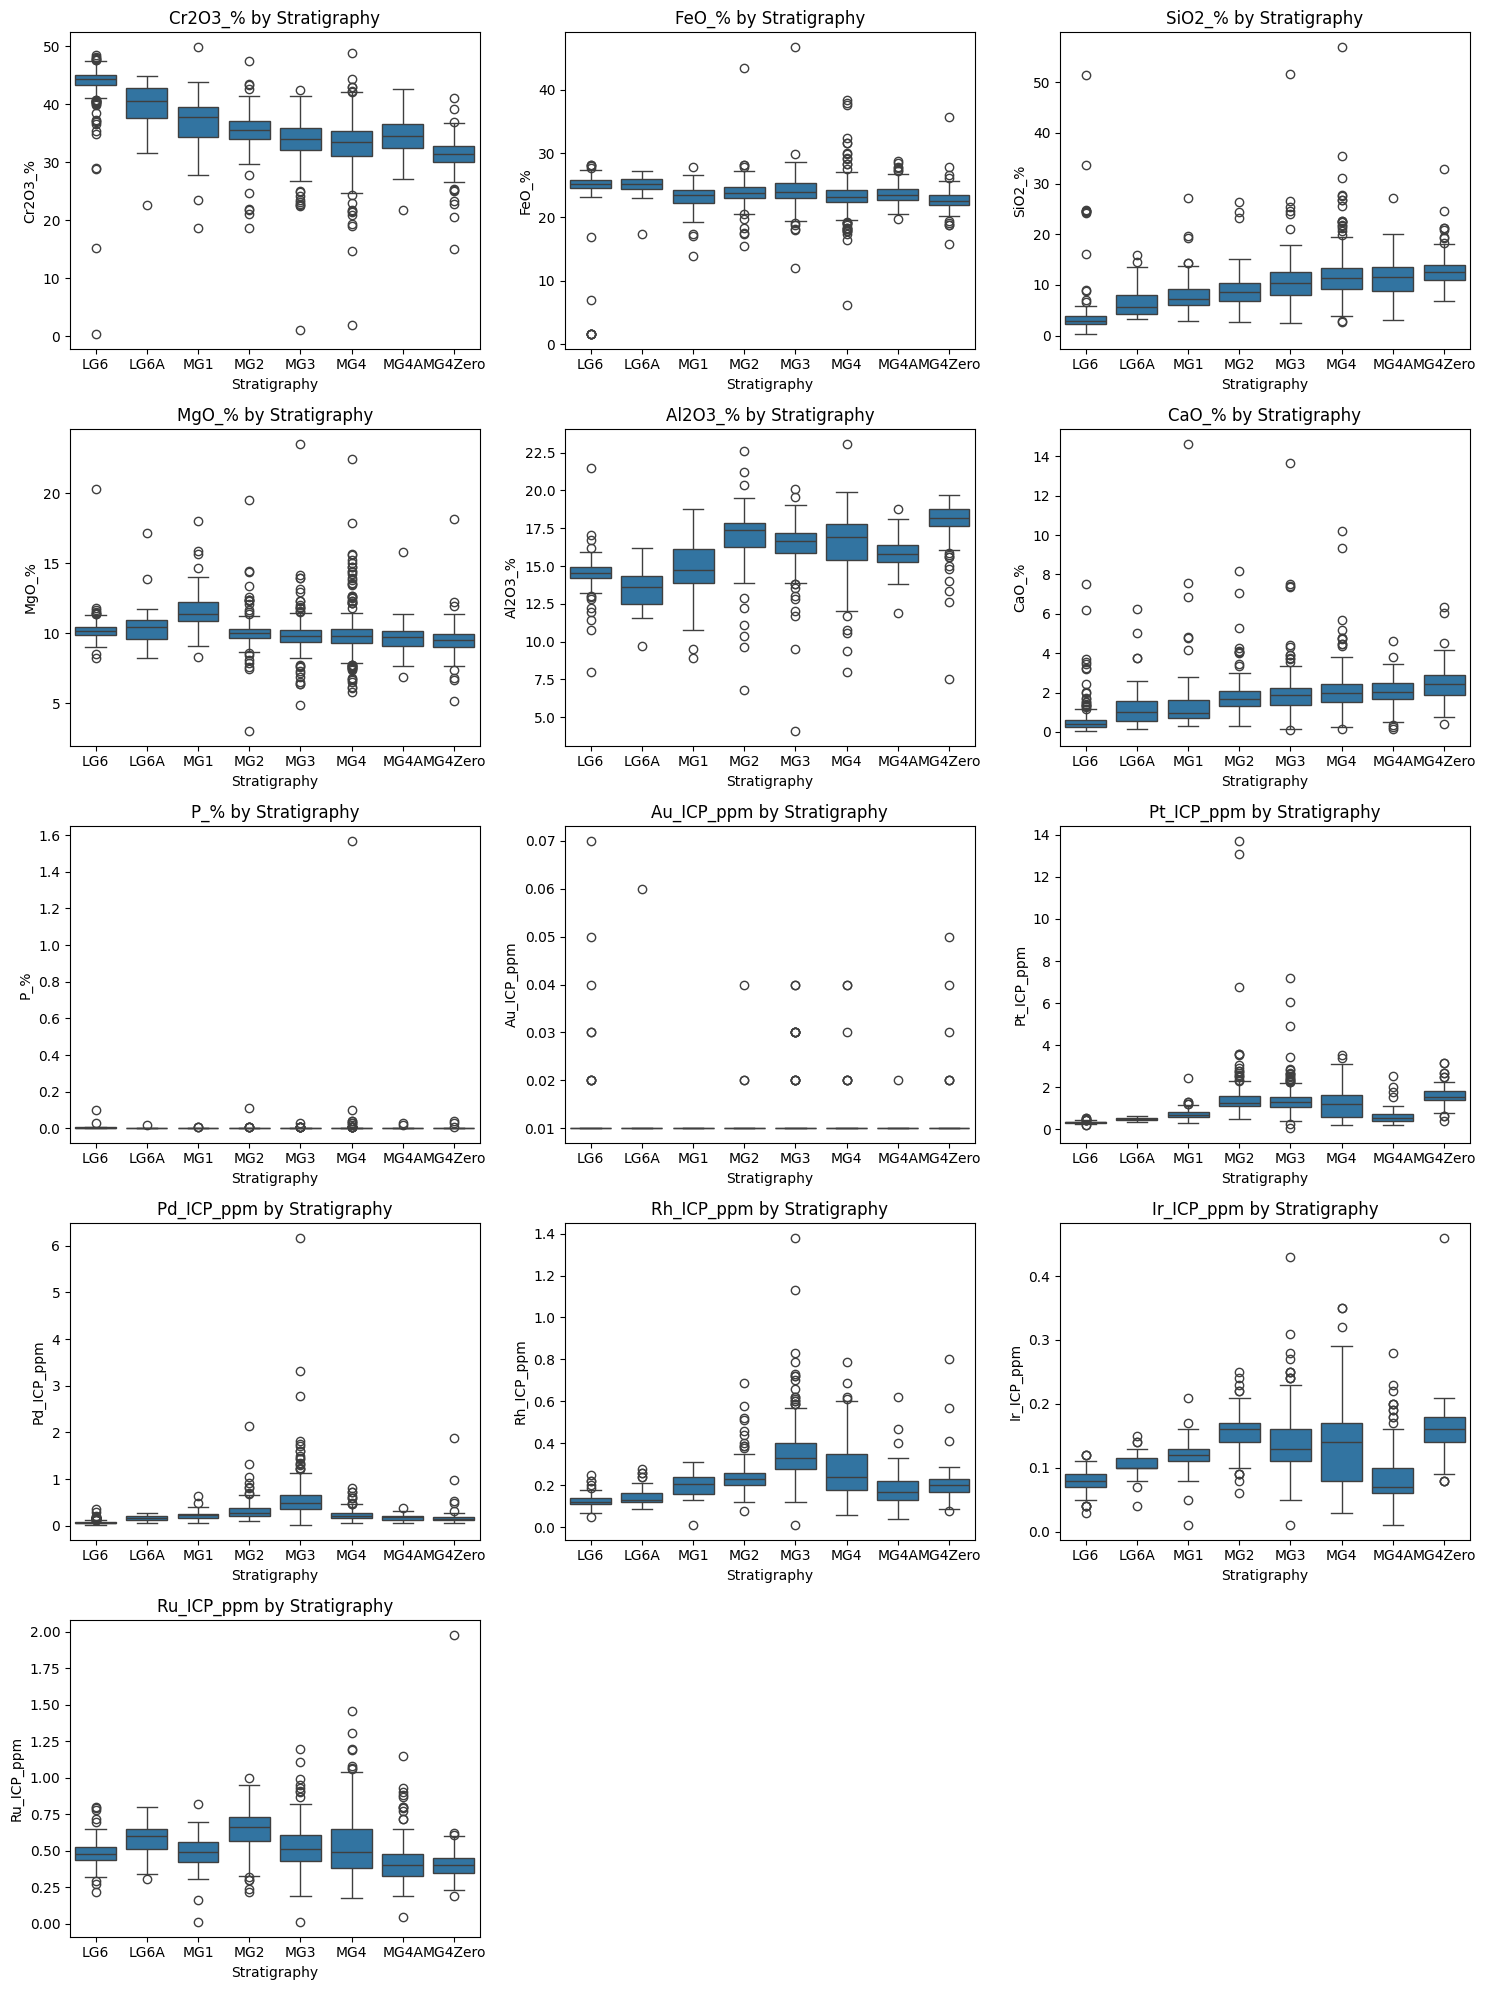

In [62]:
EDA_Box_Plot(X = data_dropped_1,
             columns = [col for col in data_dropped_1 if col.endswith('_%')] + [col for col in data_dropped_1 if col.endswith('_ppm')],
             fname = "box_plot_init.png"
            )

There a lot of data outliers as we seen in the box plot above. But, we cannot take care of that by ignore that.

We must take a different approach of that later in the feature engineeering part later.

Now, we have to make splitting on input and output data at first

In [63]:
# Based on the distribution of P_% values on scatter plot above, we can consider this one is also an anomaly
P_ano_idx = data_dropped_1[data_dropped_1['P_%'] > 1].index

In [64]:
# dropping P_ano_idx
data_dropped_2 = data_dropped_1.drop(index=P_ano_idx)
data_dropped_2 = data_dropped_2.reset_index(drop=True)
data_dropped_3 = data_dropped_2.drop(['Au_ICP_ppm'], axis=1)
data_dropped_3 = data_dropped_3.reset_index(drop=True)

In [65]:
data_dropped_3.shape

(1110, 21)

####  Input-Output Splitting
---

In [66]:
# Create a function named split_input_output
def split_input_output(data,target_col):
    """
     Create a function named split_input_output - Has two arguments:
        - data, a pd Dataframe
        - target_col, a column (str)
        - Print the data shape after splitting
     then return X, y
    """
    # drop data
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    return X,y

In [67]:
X, y = split_input_output(data=data_dropped_3,
                          target_col='Stratigraphy')

In [68]:
X.head()

,ProjectCode,BH_ID,Motherhole,HoleType,MaxDepth,DepthFrom,DepthTo,Date,Cr2O3_%,FeO_%,SiO2_%,MgO_%,Al2O3_%,CaO_%,P_%,Pt_ICP_ppm,Pd_ICP_ppm,Rh_ICP_ppm,Ir_ICP_ppm,Ru_ICP_ppm
0,J1099,SC01,SC01,borehole,274.50,232.30,233.03,01. Jul 08,42.88,23.36,4.49,9.86,14.66,0.61,0.0,0.30,0.05,0.09,0.06,0.48
1,J1098,SC02,SC02,borehole,280.70,237.75,238.32,01. Jul 08,44.59,24.65,2.73,9.61,14.35,0.38,0.0,0.31,0.04,0.11,0.05,0.40
2,J1101,SC03,SC03,borehole,289.65,242.70,243.64,01. Jul 08,44.31,24.23,2.53,10.13,14.52,0.41,0.0,0.29,0.05,0.11,0.05,0.39
3,J1114,SC04,SC04,borehole,523.00,244.64,245.51,01. Jul 08,45.04,24.91,1.84,9.64,14.42,0.32,0.0,0.33,0.04,0.13,0.05,0.49
4,J1106,SC05,SC05,borehole,486.04,394.94,395.80,01. Jul 08,46.52,24.92,1.69,9.76,13.46,0.32,0.0,0.30,0.03,0.11,0.05,0.44


In [69]:
X.describe()

,MaxDepth,DepthFrom,DepthTo,Cr2O3_%,FeO_%,SiO2_%,MgO_%,Al2O3_%,CaO_%,P_%,Pt_ICP_ppm,Pd_ICP_ppm,Rh_ICP_ppm,Ir_ICP_ppm,Ru_ICP_ppm
count,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000
mean,349.075081,126.254694,126.850297,35.933973,23.787468,9.442739,10.090081,15.982559,1.707207,0.001495,1.067928,0.271901,0.236820,0.124468,0.517982
std,206.764306,108.997464,109.087357,5.902631,2.948230,5.635127,1.474934,1.924489,1.274639,0.006776,0.900895,0.327008,0.129265,0.051070,0.170531
min,14.400000,2.900000,3.030000,0.300000,1.580000,0.270000,3.010000,4.070000,0.030000,0.000000,0.050000,0.010000,0.010000,0.010000,0.010000
25%,182.140000,40.325000,40.750000,32.372500,22.760000,5.330000,9.500000,14.700000,0.810000,0.000000,0.410000,0.120000,0.140000,0.080000,0.410000
50%,334.750000,97.635000,97.840000,35.110000,23.950000,9.370000,9.935000,16.085000,1.660000,0.000000,0.980000,0.190000,0.210000,0.120000,0.490000
75%,536.800000,173.840000,175.002500,40.030000,25.117500,12.317500,10.407500,17.407500,2.220000,0.000000,1.450000,0.317500,0.300000,0.160000,0.610000
max,666.040000,505.810000,506.790000,49.900000,46.760000,56.980000,23.540000,23.090000,14.640000,0.110000,13.720000,6.170000,1.380000,0.460000,1.980000


In [70]:
y.head()

,Stratigraphy
0,LG6
1,LG6
2,LG6
3,LG6
4,LG6


#### Train-Valid-Test Splitting
---

In [71]:
# Create a function named split_train_test

from sklearn.model_selection import train_test_split

def split_train_test(X, y, test_size, stratify, seed):
    '''Fungsi splitting data numerikal dan kategorikal
    memiliki dua argumen:
    - X, the input (pd.Dataframe)
    - y, the output (pd.Dataframe)
    - test_size, the test size between 0-1 (float)
    - seed, the random state (int)
    '''
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=test_size,
                                                        stratify = y,
                                                        random_state = seed)

    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_train shape:", y_train.shape)

    return X_train, X_test, y_train, y_test

In [72]:
# Split the data
# First, split the train & not train
X_train, X_not_train, y_train, y_not_train = split_train_test(X=X,
                                                              y=y,
                                                              test_size = 0.2,
                                                              stratify = y,
                                                              seed=123)

# Then, split the valid & test
X_valid, X_test, y_valid, y_test = split_train_test(X=X_not_train,
                                                    y=y_not_train,
                                                    test_size = 0.5,
                                                    stratify = y_not_train,
                                                    seed = 123)

X_train shape: (888, 20)
X_test shape: (222, 20)
y_train shape: (888,)
y_train shape: (888,)
X_train shape: (111, 20)
X_test shape: (111, 20)
y_train shape: (111,)
y_train shape: (111,)


In [73]:
# Validate
print(len(X_train)/len(X))  # should be 0.8
print(len(X_valid)/len(X))  # should be 0.1
print(len(X_test)/len(X))   # should be 0.1

0.8
0.1
0.1


In [74]:
X_train.head()

,ProjectCode,BH_ID,Motherhole,HoleType,MaxDepth,DepthFrom,DepthTo,Date,Cr2O3_%,FeO_%,SiO2_%,MgO_%,Al2O3_%,CaO_%,P_%,Pt_ICP_ppm,Pd_ICP_ppm,Rh_ICP_ppm,Ir_ICP_ppm,Ru_ICP_ppm
152,J1095,SC26 D1,SC26,deflection,334.27,329.19,330.33,08. Sep 09,43.94,25.89,2.34,10.32,15.06,0.30,0.01,0.31,0.07,0.12,0.08,0.51
819,J1936,ZK136,ZK136,borehole,281.16,73.18,73.41,19. Sep 13,34.71,23.02,12.90,9.60,14.80,1.96,0.00,0.33,0.16,0.13,0.06,0.28
802,J1931,ZK134,ZK134,borehole,284.54,91.90,92.16,19. Sep 13,32.10,25.26,11.90,11.00,14.70,2.06,0.00,0.24,0.18,0.20,0.06,0.31
424,J1480,RD16,RD16,borehole,50.32,47.72,48.26,13. Jan 10,33.85,24.12,11.35,10.80,14.14,2.22,0.11,1.25,0.44,0.22,0.11,0.60
635,J1120,ZK73,ZK73,borehole,472.65,107.13,107.33,17. Feb 09,30.26,25.82,10.61,8.42,16.43,2.69,0.00,1.39,0.65,0.34,0.14,0.49


---
### **Splitting the Data**

for Imputation in Numerical and Categorical type of data

In [75]:
# Create a function to split numerical & categorical input
def split_num_cat(data):
    '''
    fungsi splitting data numerik dan data kategorikal
    parameter:
    - data, an input data (pd. Dataframe)
    - num_cols, a list of numerical columns (list)
    - cat_cols, a list of categorical columns (list)
    '''
    num_cols = data.select_dtypes(include = ['number','datetime']).columns.tolist()
    cat_cols = data.select_dtypes(include = ['object','category']).columns.tolist()

    numerical_data = data[num_cols]
    categorical_data = data[cat_cols]

    print("numerical data:", numerical_data)
    print("categorical data:", categorical_data)

    return numerical_data, categorical_data

In [76]:
# Split the data
X_train_num, X_train_cat = split_num_cat(data=X_train)# WRITE YOUR CODE HERE

numerical data:       MaxDepth  DepthFrom  DepthTo  Cr2O3_%  FeO_%  SiO2_%  MgO_%  Al2O3_%  \
152     334.27     329.19   330.33    43.94  25.89    2.34  10.32    15.06   
819     281.16      73.18    73.41    34.71  23.02   12.90   9.60    14.80   
802     284.54      91.90    92.16    32.10  25.26   11.90  11.00    14.70   
424      50.32      47.72    48.26    33.85  24.12   11.35  10.80    14.14   
635     472.65     107.13   107.33    30.26  25.82   10.61   8.42    16.43   
...        ...        ...      ...      ...    ...     ...    ...      ...   
696     639.35     178.19   178.30    34.50  23.54    9.96   9.89    16.95   
346     652.65     242.02   242.51    34.86  23.96   10.00  10.49    16.62   
1077    652.65     199.41   199.60    30.99  22.54   13.16  10.02    18.65   
951     182.14      17.19    17.39    34.84  24.62    8.80   9.10    15.60   
369     562.45     194.74   195.28    35.08  24.03    8.00   9.82    17.44   

      CaO_%   P_%  Pt_ICP_ppm  Pd_ICP_ppm  Rh_I

In [77]:
# check the data if we have to do imputation or not
X_train_num.isna().sum(0)

,0
MaxDepth,0
DepthFrom,0
DepthTo,0
Cr2O3_%,0
FeO_%,0
SiO2_%,0
MgO_%,0
Al2O3_%,0
CaO_%,0
P_%,0


there's no need for us to imputing numerical data

---
### **Categorical Imputation Step for Missing Values**

Is it necessary step?

In [78]:
X_train_cat.describe()

,ProjectCode,BH_ID,Motherhole,HoleType,Date
count,888,888,888,888,888
unique,113,280,208,2,18
top,J1095,ZK146,ZK146,borehole,19. Sep 13
freq,80,15,15,811,157


In [79]:
# Check missing value (JUST RUN THE CODE)
X_train_cat.value_counts(normalize=True)

ProjectCode  BH_ID    Motherhole  HoleType    Date      
J1095        ZK86     ZK86        borehole    23. Feb 09    0.010135
             SC04 D1  SC04        deflection  08. Sep 09    0.001126
J1477        EL12     EL12        borehole    23. Okt 09    0.001126
J1476        MD14     MD14        borehole    17. Sep 13    0.001126
             RD01     RD01        borehole    09. Nov 09    0.001126
                                                              ...   
J1116        SC38     SC38        borehole    23. Feb 09    0.001126
             SC41     SC41        borehole    07. Feb 09    0.001126
             SC46     SC46        borehole    23. Jan 09    0.001126
             SC47     SC47        borehole    23. Feb 09    0.001126
J1943        ZK135    ZK135       borehole    19. Sep 13    0.001126
Name: proportion, Length: 880, dtype: float64

In [80]:
# Create function to fit & transform categorical imputers
from sklearn.impute import SimpleImputer

def cat_imputer_fit(data):
    """
    Fungsi untuk melakukan imputasi data kategorikal
    :param data: <pandas dataframe> sample data input (X_train_cat)

    :return imputer_data: data yang melalui tahap fitting
    """
    # Buat imputer
    imputer_cat_data = SimpleImputer(missing_values = "-",
                                     strategy = "constant",
                                     fill_value = "UNKNOWN")
    imputer_cat_data.fit(data)

    return imputer_cat_data

def cat_imputer_transform(data, imputer_cat_data):
    """
    Fungsi untuk melakukan transformasi data kategorikal
    :param data: imputer_data
    :return imputed_data: data yang telah ditransformasi
    """
    # Transform
    imputed_cat_data = imputer_cat_data.transform(data)
    imputed_cat_data_df = pd.DataFrame(imputed_cat_data,
                                   columns=data.columns,
                                   index=data.index)

    return imputed_cat_data_df

In [81]:
# Perform categorical imputation
cat_imputer = cat_imputer_fit(data = X_train_cat)# WRITE YOUR CODE HERE

# Transform
X_train_cat_imputed = cat_imputer_transform(data = X_train_cat, imputer_cat_data = cat_imputer)# WRITE YOUR CODE HERE

# Validation
X_train_cat_imputed.value_counts(normalize=True)

In [82]:
X_train_cat_imputed.describe()

,ProjectCode,BH_ID,Motherhole,HoleType,Date
count,888,888,888,888,888
unique,113,280,208,2,18
top,J1095,ZK146,ZK146,borehole,19. Sep 13
freq,80,15,15,811,157


In [83]:
X_train_cat_imputed[X_train_cat_imputed.eq('UNKNOWN').any(axis=1)]

,ProjectCode,BH_ID,Motherhole,HoleType,Date


**Kesimpulan**: categorical imputation function *tidak diperlukan*, kita cukup fokus di feature engineering data numerik

---
### **Categorical Encoding Step: Using One Hot Encoder**

OHE Encoding and Transformation Function

In [84]:
from sklearn.preprocessing import OneHotEncoder

def encoderCat(data, encoder_col = None, encoder = None):
    if encoder == None:
        # Buat objek
        encoder = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")
        encoder.fit(data)

    # Transform data
    data_encoded = encoder.transform(data)
    data_encoded = pd.DataFrame(data_encoded, index=data.index)

    return data_encoded, encoder

In [85]:
X_train_cat_encoded, encoder_OHE = encoderCat(data = X_train_cat_imputed)

In [86]:
X_train_cat_encoded

,0,1,2,3,4,5,6,7,8,9,...,611,612,613,614,615,616,617,618,619,620
152,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


---
## Feature Engineering on Numerical Data Columns

**Isometric Log Ratio** - Brief Explanation

Directly processing compositional data is not appropriate because it can lead to misleading results due to the **closed nature of compositional data**. Compositional data are constrained by a constant sum (e.g., 100%), which means the components are **not independent of each other**. This can result in <u>spurious correlations and biased analyses</u> if traditional statistical methods are applied without transformation.

For example, if one component increases, another must decrease to maintain the constant sum, even if there is no true negative correlation between the components. This dependency can distort the results of any analysis conducted on the raw compositional data.

In **geological context**, a rock composed of different minerals may be a compositional data point in a sample of rocks;
a rock of which 10% is the first mineral, 30% is the second, and the remaining 60% is the third would correspond to the triple [0.1, 0.3, 0.6].
A data set would contain one such triple for each rock in a sample of rocks.

The isometric log ratio (ilr) transform is both an isomorphism and an isometry where:

$$
ILR >> S^{\text{D}} -> R^{\text{D-1}}
$$
$$
ILR (x) = C[exp(0,....,0, a,...,a, b,....,b, 0,.....,0) ]
$$
where series of first 0 can be declared as k, series of a can be declared as r, and series of b can be declared as s, and series of first 0 can be declared as t

There are multiple ways to construct orthonormal bases,
including using the Gram–Schmidt orthogonalization or singular-value decomposition of clr transformed data.
Another alternative is to construct log contrasts from a bifurcating tree.
If we are given a bifurcating tree, we can construct a basis from the internal nodes in the tree.

Each vector in the basis would be determined as follows:

$$
e = [(x,e_{\text{1}}), (x,e_{\text{1}}), (x,e_{\text{1}}), ...,(x_{\text{n}},e_{\text{D-1}}) ]
$$

Then, the elements within each vector are given as follows:

$$
\begin{align*}
a = \cfrac{\sqrt(s)}{\sqrt(r(r+s)}\\
b = \cfrac{\sqrt(-r)}{\sqrt(r(r+s)}
\end{align*}
$$

where `k`,`r`,`s`,`t`, are the respective number of tips in the corresponding subtrees shown in the figure. It can be shown that the resulting  orthonormal (3).

Once the basis of ${\psi}$ is built, the ilr transforms can be calculated as follows:

$$
ilr (x) = clr (x) X^{\text{T}}
$$

where each element in the ilr transformed data is of the following form

$$
b_{\text{i}} = \cfrac{\sqrt(rs)}{\sqrt(r(r+s)}\log \cfrac{g(x_\text{R})}{g(x_\text{S})}
$$

where $x_\text{R}$ and $x_\text{S}$ are the set of values corresponding to the tips in the subtrees `R` and `S`

---
**Splitting the numerical column target for feature engineering step**

In [87]:
# Create a function named split_input_output
def split_num_fe(data):
    """
     Create a function named split_input_output - Has two arguments:
        - data, a pd Dataframe
        - target_col, a column (str)
        - Print the data shape after splitting
     then return X, y
    """
    # splitting and filtering
    percent_and_ppm_columns = ['Cr2O3_%', 'FeO_%', 'SiO2_%', 'Al2O3_%', 'CaO_%', 'MgO_%', 'P_%',
                               'Pt_ICP_ppm', 'Pd_ICP_ppm', 'Rh_ICP_ppm', 'Ir_ICP_ppm', 'Ru_ICP_ppm']

    other_columns = ["MaxDepth","DepthFrom","DepthTo"]

    data_num_to_ilr = data[percent_and_ppm_columns]
    data_num_non_ilr = data[other_columns]
    return data_num_to_ilr,data_num_non_ilr

In [88]:
X_train_num_toilr, X_train_num_nonilr = split_num_fe(data=X_train_num)

In [89]:
X_train_num_toilr

,Cr2O3_%,FeO_%,SiO2_%,Al2O3_%,CaO_%,MgO_%,P_%,Pt_ICP_ppm,Pd_ICP_ppm,Rh_ICP_ppm,Ir_ICP_ppm,Ru_ICP_ppm
152,43.94,25.89,2.34,15.06,0.30,10.32,0.01,0.31,0.07,0.12,0.08,0.51
819,34.71,23.02,12.90,14.80,1.96,9.60,0.00,0.33,0.16,0.13,0.06,0.28
802,32.10,25.26,11.90,14.70,2.06,11.00,0.00,0.24,0.18,0.20,0.06,0.31
424,33.85,24.12,11.35,14.14,2.22,10.80,0.11,1.25,0.44,0.22,0.11,0.60
635,30.26,25.82,10.61,16.43,2.69,8.42,0.00,1.39,0.65,0.34,0.14,0.49
...,...,...,...,...,...,...,...,...,...,...,...,...
696,34.50,23.54,9.96,16.95,1.66,9.89,0.00,1.85,0.49,0.58,0.14,0.73
346,34.86,23.96,10.00,16.62,1.29,10.49,0.00,1.16,0.30,0.19,0.15,0.67
1077,30.99,22.54,13.16,18.65,1.84,10.02,0.00,1.57,0.16,0.23,0.17,0.46
951,34.84,24.62,8.80,15.60,2.54,9.10,0.00,0.33,0.17,0.08,0.07,0.38


In [90]:
X_train_num_nonilr

,MaxDepth,DepthFrom,DepthTo
152,334.27,329.19,330.33
819,281.16,73.18,73.41
802,284.54,91.90,92.16
424,50.32,47.72,48.26
635,472.65,107.13,107.33
...,...,...,...
696,639.35,178.19,178.30
346,652.65,242.02,242.51
1077,652.65,199.41,199.60
951,182.14,17.19,17.39


---
**Feature engineering step using ILR and Closure conversion function, via scikit-bio library**

ILR transformation reduces the dimensionality of the data by one, the output will always have one less column than the input.
This happens because the isometric log-ratio (ILR) transformation is a projection
that operates in a lower-dimensional space (from 𝑛 parts to 𝑛−1).

In [91]:
# import library required for compostitional data analysis
from skbio.stats.composition import ilr, closure

def ilr_converter(data_num):
    # Create a copy to avoid SettingWithCopyWarning
    data_num = data_num.copy()

    # All relevant columns including percentages and ppm
    columns = data_num.columns.tolist()

    # Automatically filter ppm columns
    ppm_columns = [col for col in columns if col.endswith('_ppm')]

    # Apply conversion to ppm columns directly, avoiding slice assignment
    data_num[ppm_columns] = data_num[ppm_columns].apply(lambda x: x * 0.0001)

    # Get the percentage and ppm data as a NumPy array
    percent_data = data_num[columns].to_numpy()

    # Normalization using closure
    percent_data_closure = closure(percent_data)

    # Avoid log(0) issues by replacing 0 with a small value
    epsilon = 1e-6
    percent_data_closure[percent_data_closure == 0] = epsilon

    # Perform ILR transformation
    percent_ilr = ilr(percent_data_closure)

    # Create DataFrame for ILR-transformed data
    ilr_transformed_columns = [f'ILR_{col}' for col in columns[:-1]]
    percent_ilr_data_num = pd.DataFrame(percent_ilr, columns=[ilr_transformed_columns])

    return percent_ilr_data_num

In [92]:
X_train_num_ilr = ilr_converter(data_num = X_train_num_toilr)

In [93]:
X_train_num_ilr

,ILR_Cr2O3_%,ILR_FeO_%,ILR_SiO2_%,ILR_Al2O3_%,ILR_CaO_%,ILR_MgO_%,ILR_P_%,ILR_Pt_ICP_ppm,ILR_Pd_ICP_ppm,ILR_Rh_ICP_ppm,ILR_Ir_ICP_ppm
0,0.374037,2.178568,-0.071965,3.446847,-0.415451,6.073381,10.662986,10.806842,9.154596,8.667240,6.138549
1,0.290384,0.640516,0.333921,2.066902,0.237232,10.849896,10.404757,9.858650,9.014829,8.891427,6.641862
2,0.169447,0.712394,0.320739,2.006120,0.108758,10.867063,10.717800,9.723440,8.596956,8.924182,6.574313
3,0.239637,0.753849,0.342708,1.921493,0.124695,4.351958,10.110942,9.901422,9.513679,9.266336,6.834742
4,0.112202,0.790933,0.180551,1.758381,0.394063,10.887744,9.065437,8.711581,8.406647,8.450109,6.514429
...,...,...,...,...,...,...,...,...,...,...,...
883,0.270297,0.858345,0.146484,2.191623,0.160246,10.817070,8.759082,8.977339,7.869607,8.473565,6.154174
884,0.265133,0.866530,0.172769,2.419951,0.062705,10.782282,9.172525,9.364455,8.809142,8.193557,6.046734
885,0.225124,0.569340,0.100632,2.149515,0.207922,10.862764,8.958924,10.054081,8.648361,8.110950,6.451201
886,0.245512,0.981764,0.198396,1.777158,0.286119,10.856025,10.395584,9.793403,9.474576,8.697394,6.319942


In [94]:
X_train_num

,MaxDepth,DepthFrom,DepthTo,Cr2O3_%,FeO_%,SiO2_%,MgO_%,Al2O3_%,CaO_%,P_%,Pt_ICP_ppm,Pd_ICP_ppm,Rh_ICP_ppm,Ir_ICP_ppm,Ru_ICP_ppm
152,334.27,329.19,330.33,43.94,25.89,2.34,10.32,15.06,0.30,0.01,0.31,0.07,0.12,0.08,0.51
819,281.16,73.18,73.41,34.71,23.02,12.90,9.60,14.80,1.96,0.00,0.33,0.16,0.13,0.06,0.28
802,284.54,91.90,92.16,32.10,25.26,11.90,11.00,14.70,2.06,0.00,0.24,0.18,0.20,0.06,0.31
424,50.32,47.72,48.26,33.85,24.12,11.35,10.80,14.14,2.22,0.11,1.25,0.44,0.22,0.11,0.60
635,472.65,107.13,107.33,30.26,25.82,10.61,8.42,16.43,2.69,0.00,1.39,0.65,0.34,0.14,0.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,639.35,178.19,178.30,34.50,23.54,9.96,9.89,16.95,1.66,0.00,1.85,0.49,0.58,0.14,0.73
346,652.65,242.02,242.51,34.86,23.96,10.00,10.49,16.62,1.29,0.00,1.16,0.30,0.19,0.15,0.67
1077,652.65,199.41,199.60,30.99,22.54,13.16,10.02,18.65,1.84,0.00,1.57,0.16,0.23,0.17,0.46
951,182.14,17.19,17.39,34.84,24.62,8.80,9.10,15.60,2.54,0.00,0.33,0.17,0.08,0.07,0.38


---
### Concatenating Pre-processed Data

In [95]:
# Create a function to join / concat the data

def concat_data(num_data1, num_data2, cat_data):
    '''fungsi penggabungan data numerikal dan kategorikal'''

    if num_data1.index.equals(num_data2.index) is False:
        num_data2 = num_data2.reindex(num_data1.index)

    concatenated_data_num = pd.concat([num_data1, num_data2],axis=1)

    if concatenated_data_num.index.equals(cat_data.index) is False:
        cat_data = cat_data.reindex(concatenated_data_num.index)

    concatenated_data_final = pd.concat([concatenated_data_num, cat_data],axis=1)

    print("numerical (1) data shape:", num_data1.shape)
    print("numerical (2) data shape:", num_data2.shape)
    print("categorical data shape:", cat_data.shape)
    print("numerical-concatenated data shape:", concatenated_data_num.shape)
    print("concatenated data shape:", concatenated_data_final.shape)

    return concatenated_data_num, concatenated_data_final

In [96]:
# Concat the data
X_train_num, X_train_concat = concat_data(num_data1 = X_train_num_nonilr, num_data2 = X_train_num_ilr, cat_data = X_train_cat_encoded)

numerical (1) data shape: (888, 3)
numerical (2) data shape: (888, 11)
categorical data shape: (888, 621)
numerical-concatenated data shape: (888, 14)
concatenated data shape: (888, 635)


In [97]:
# for box plot purposes, we once again concatenating pre_processed data_train with y_train
data_train_concat = pd.concat([X_train_concat, y_train],axis=1)

In [98]:
data_train_concat

,MaxDepth,DepthFrom,DepthTo,"(ILR_Cr2O3_%,)","(ILR_FeO_%,)","(ILR_SiO2_%,)","(ILR_Al2O3_%,)","(ILR_CaO_%,)","(ILR_MgO_%,)","(ILR_P_%,)",...,612,613,614,615,616,617,618,619,620,Stratigraphy
152,334.27,329.19,330.33,0.253958,0.922623,0.133696,2.273455,0.111116,10.798366,9.167263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LG6
819,281.16,73.18,73.41,0.303852,0.760924,0.052283,2.035643,0.248617,10.851881,8.873141,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MG4
802,284.54,91.90,92.16,0.253407,0.810509,0.116904,2.250603,0.168869,10.816043,9.213789,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MG4
424,50.32,47.72,48.26,0.097572,0.152690,0.307938,1.912428,0.036260,10.934959,9.299344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MG2
635,472.65,107.13,107.33,0.324910,1.421054,0.196244,2.678742,-0.129454,10.640250,9.908178,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MG3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,639.35,178.19,178.30,0.288122,0.983949,0.061255,2.138114,0.119900,10.811303,8.770543,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MG4
346,652.65,242.02,242.51,0.289684,1.251406,0.260494,2.775125,-0.105804,10.655041,9.802610,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,MG2
1077,652.65,199.41,199.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MG4Zero
951,182.14,17.19,17.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MG4A


Visualize the relationship between the stratigraphic layers (target variable) and the ILR-transformed compositional variables using box plots.

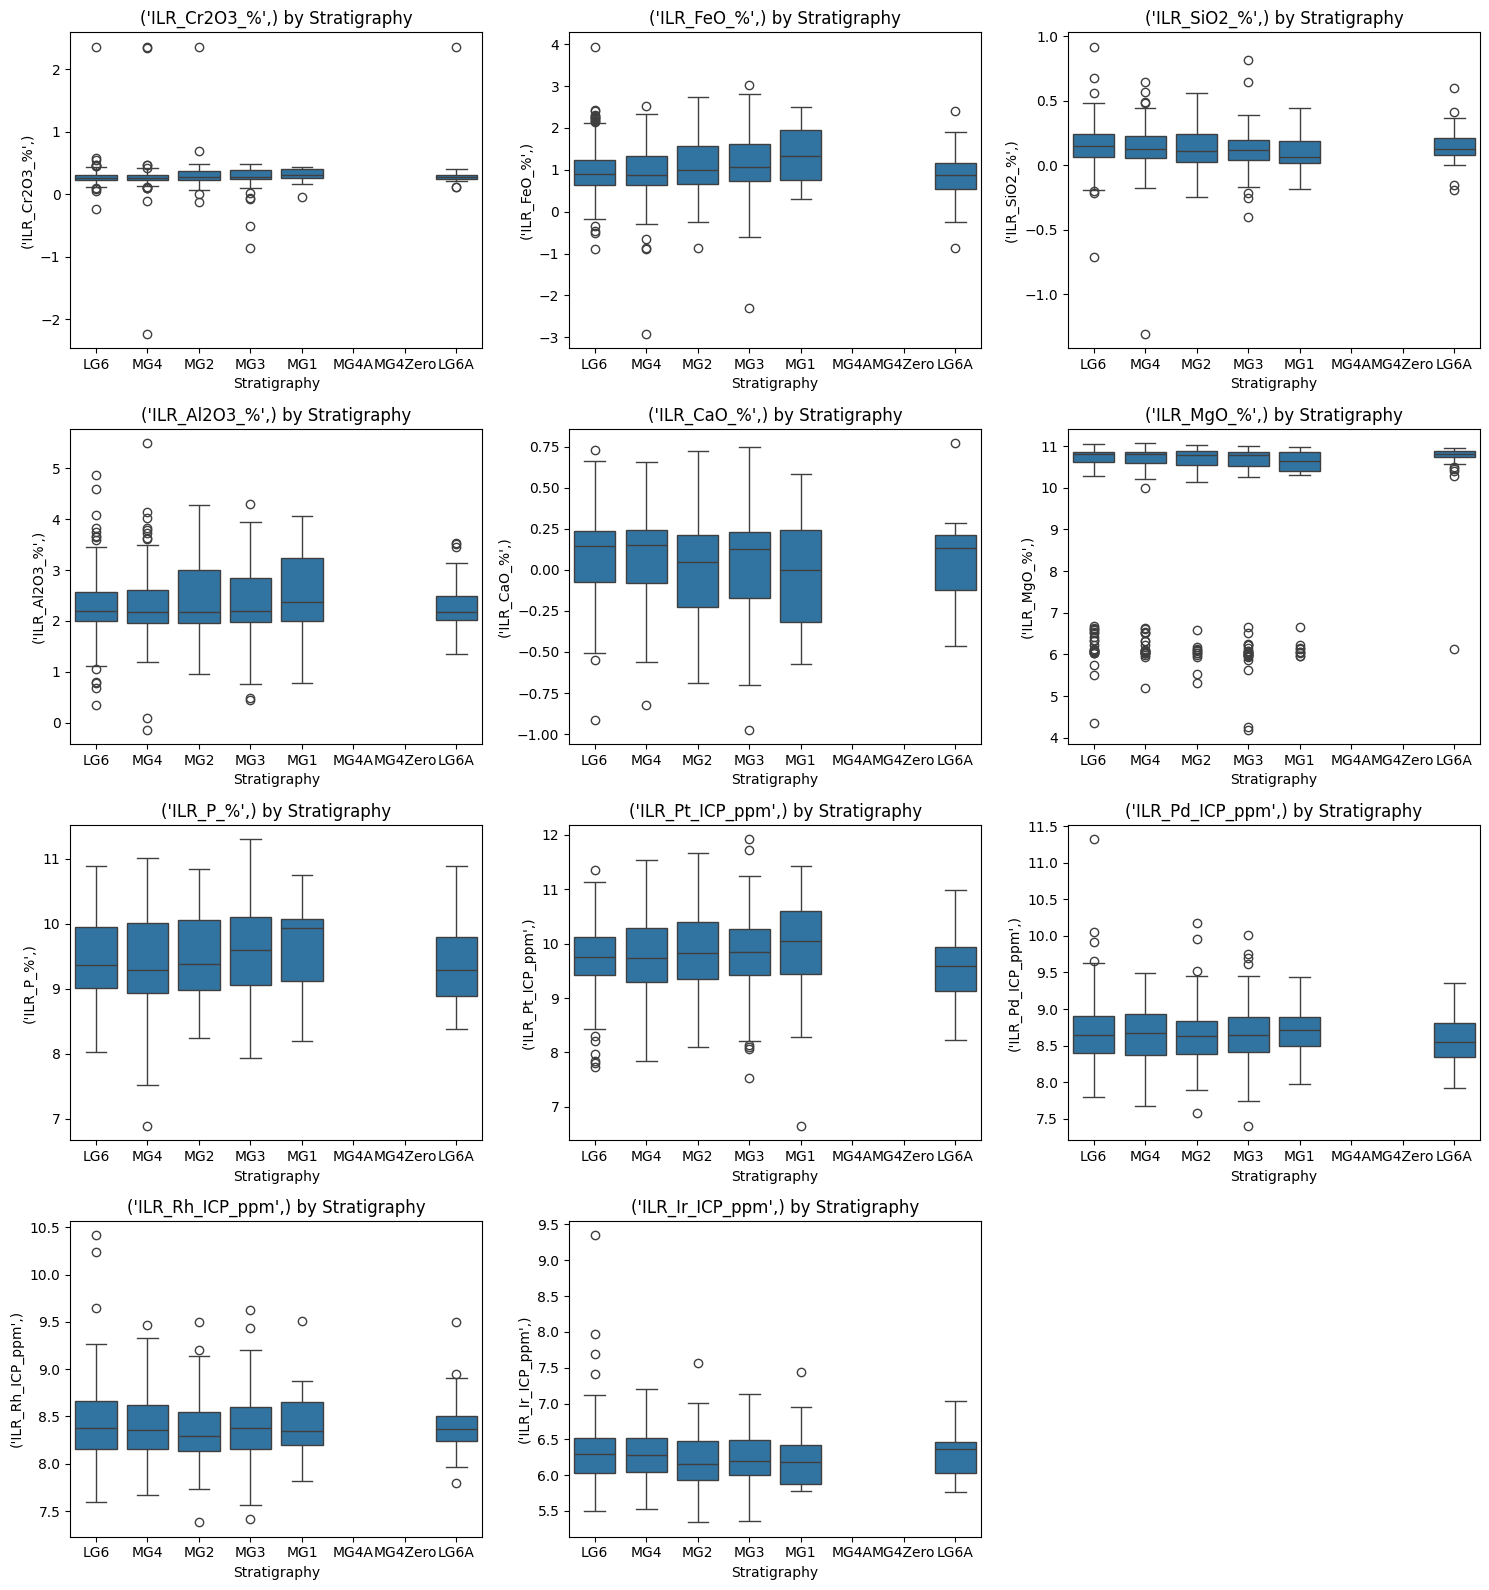

In [99]:
# Visualize new EDA plot
EDA_Box_Plot(X = data_train_concat, columns = X_train_num_ilr.columns.tolist(), fname = "box_plot_transformed.png")

Scaling the dataset (for comparative purposes later)

In [100]:
from sklearn.preprocessing import StandardScaler
# Buat fungsi scaling dan transforming sekaligus
def scaler_transform(X, scaler = None):
    """
    Fungsi untuk melakukan standardisasi
    :param X: <pandas DataFrame> sampel data
    :param scaler: <sklearn object> scaler, default None
    :return X_scaled: <pandas Dataframe> sampel data OHE
    :param scaler: <sklearn object> scaler, default None
    """
    # Ensure all column names are strings
    X.columns = X.columns.astype(str)

    if scaler is not None:
        pass

    else:
        # Create & fit the scaler
        scaler = StandardScaler()
        scaler.fit(X)

    # Transform the data
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    return X_scaled, scaler

In [101]:
X_train_clean, scaler = scaler_transform(X = X_train_concat)
X_train_clean.head()

,MaxDepth,DepthFrom,DepthTo,"('ILR_Cr2O3_%',)","('ILR_FeO_%',)","('ILR_SiO2_%',)","('ILR_Al2O3_%',)","('ILR_CaO_%',)","('ILR_MgO_%',)","('ILR_P_%',)",...,611,612,613,614,615,616,617,618,619,620
152,-0.112237,1.872095,1.875497,-0.177529,-0.208270,0.003333,-0.136882,0.245022,0.391065,-0.511871,...,-0.186989,-0.143839,-0.356235,-0.463437,-0.155632,-0.249401,-0.297044,-0.264347,-0.220014,-0.208514
819,-0.374181,-0.516990,-0.519904,0.045570,-0.449118,-0.500984,-0.489467,0.740657,0.425967,-0.948653,...,-0.186989,-0.143839,-0.356235,2.157788,-0.155632,-0.249401,-0.297044,-0.264347,-0.220014,-0.208514
802,-0.357511,-0.342295,-0.345088,-0.179994,-0.375261,-0.100685,-0.170763,0.453197,0.402594,-0.442777,...,-0.186989,-0.143839,-0.356235,2.157788,-0.155632,-0.249401,-0.297044,-0.264347,-0.220014,-0.208514
424,-1.512709,-0.754583,-0.754391,-0.876813,-1.355065,1.082686,-0.672149,-0.024803,0.480150,-0.315724,...,-0.186989,-0.143839,-0.356235,-0.463437,-0.155632,-0.249401,-0.297044,-0.264347,-0.220014,-0.208514
635,0.570268,-0.200169,-0.203650,0.139730,0.534129,0.390795,0.464005,-0.622134,0.287945,0.588419,...,-0.186989,6.952218,-0.356235,-0.463437,-0.155632,-0.249401,-0.297044,-0.264347,-0.220014,-0.208514


Succeaafully scaled! Let's wrap it as pre-processing function

---
### Making Pre-Processing Function for Train Dataset, Start from Splitting to Concatenating

In this step will create two functions in order to compare the model accuracy result,
since Isometric Log Ratio (ILR) itself already a scaling method

Without Scaling Step

In [102]:
# Version Witout Scaling

from skbio.stats.composition import ilr, closure
from sklearn.preprocessing import OneHotEncoder


def preprocess_data(data, cat_imputer=None, cat_encoder=None, dataset_type = 'train'):
    """
    Preprocess data for training, validation, and test sets while avoiding data leakage.

    :param data: <pandas dataframe> input data
    :return: preprocessed data, percent_closure, percent_ilr
    """

    # Split data into numerical and categorical columns
    num_cols = data.select_dtypes(include=['number']).columns.tolist()
    cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

    num_data = data[num_cols]
    cat_data = data[cat_cols]

    if dataset_type == 'train':
         # Fit and transform the categorical data (train only)
        cat_imputer = SimpleImputer(strategy="constant", fill_value="UNKNOWN")
        cat_data_imputed = cat_imputer.fit_transform(cat_data)

        # Fit and transform the categorical encodings (train only)
        cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        cat_data_encoded = cat_encoder.fit_transform(cat_data_imputed)
        # cat_encoded_data = pd.DataFrame(cat_data_encoded, columns=cat_cols)

    else:
        # Categorical imputation (only transform)
        cat_data_imputed = cat_imputer.transform(cat_data)

        # Categorical encoding (only transform using the fitted encoders)
        cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
        # Categorical imputation (transform only)
        cat_data_imputed = cat_imputer.transform(cat_data)

        # Categorical encoding using the fitted OneHotEncoder (transform only)
        cat_data_encoded = cat_encoder.transform(cat_data_imputed)
        # cat_encoded_data = pd.DataFrame(cat_data_encoded, columns=cat_cols)

    # Splitting numerical columns for ilr transformation
    percent_and_ppm_columns = ['Cr2O3_%', 'FeO_%', 'SiO2_%', 'Al2O3_%', 'CaO_%', 'MgO_%', 'P_%',
                              'Pt_ICP_ppm', 'Pd_ICP_ppm', 'Rh_ICP_ppm', 'Ir_ICP_ppm', 'Ru_ICP_ppm']

    other_columns = ["MaxDepth", "DepthFrom", "DepthTo"]  # Non-ilr columns

    data_num_to_ilr = num_data[percent_and_ppm_columns].copy()
    data_num_non_ilr = num_data[other_columns].copy()

    # Convert ppm columns (not percentages) to same scale
    ppm_columns = [col for col in data_num_to_ilr.columns if col.endswith('_ppm')]
    data_num_to_ilr[ppm_columns] *= 0.0001  # Vectorized operation instead of apply

    # Get the percentage and ppm data as a NumPy array
    percent_data = data_num_to_ilr.to_numpy()

    # Normalization using closure
    percent_closure = closure(percent_data)

    # Avoid log(0) issues by replacing 0 with a small value
    epsilon = 1e-6
    percent_closure[percent_closure == 0] = epsilon

    # Perform ILR transformation
    percent_ilr = ilr(percent_closure)

    # ILR transformation returns one less dimension (11 columns from 12 inputs)
    ilr_transformed_columns = [f'ILR_{col}' for col in percent_and_ppm_columns[:-1]]
    num_data_ilr = pd.DataFrame(percent_ilr, columns=ilr_transformed_columns, index=data.index)

    # Concatenate numerical non-ilr and ilr-transformed columns
    num_concat = pd.concat([data_num_non_ilr, num_data_ilr], axis=1)

    # Concatenate numerical and one-hot encoded categorical data
    cat_data_encoded_df = pd.DataFrame(cat_data_encoded, index=data.index, columns=cat_encoder.get_feature_names_out(cat_cols))
    data_concat = pd.concat([cat_data_encoded_df, num_concat], axis=1)

    # Ensure all column names are strings
    data_concat.columns = data_concat.columns.astype(str)

    data_cleaned = data_concat

    # Check final output shape
    print(f"Initial shape: {data.shape}, Final shape: {data_cleaned.shape}")

    return data_cleaned, cat_imputer, cat_encoder, percent_closure, percent_ilr

With Scaling

In [103]:
# Version With Scaling
from skbio.stats.composition import ilr, closure
from sklearn.preprocessing import OneHotEncoder


def preprocess_data_scaling(data, cat_imputer=None, cat_encoder=None, dataset_type = 'train'):
    """
    Preprocess data for training, validation, and test sets while avoiding data leakage.

    :param data: <pandas dataframe> input data
    :return: preprocessed data, percent_closure, percent_ilr
    """

    # Split data into numerical and categorical columns
    num_cols = data.select_dtypes(include=['number']).columns.tolist()
    cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

    num_data = data[num_cols]
    cat_data = data[cat_cols]

    if dataset_type == 'train':
         # Fit and transform the categorical data (train only)
        cat_imputer = SimpleImputer(strategy="constant", fill_value="UNKNOWN")
        cat_data_imputed = cat_imputer.fit_transform(cat_data)

        # Fit and transform the categorical encodings (train only)
        cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        cat_data_encoded = cat_encoder.fit_transform(cat_data_imputed)
        # cat_encoded_data = pd.DataFrame(cat_data_encoded, columns=cat_cols)

    else:
        # Categorical imputation (only transform)
        cat_data_imputed = cat_imputer.transform(cat_data)

        # Categorical encoding (only transform using the fitted encoders)
        cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
        # Categorical imputation (transform only)
        cat_data_imputed = cat_imputer.transform(cat_data)

        # Categorical encoding using the fitted OneHotEncoder (transform only)
        cat_data_encoded = cat_encoder.transform(cat_data_imputed)
        # cat_encoded_data = pd.DataFrame(cat_data_encoded, columns=cat_cols)

    # Splitting numerical columns for ilr transformation
    percent_and_ppm_columns = ['Cr2O3_%', 'FeO_%', 'SiO2_%', 'Al2O3_%', 'CaO_%', 'MgO_%', 'P_%',
                              'Pt_ICP_ppm', 'Pd_ICP_ppm', 'Rh_ICP_ppm', 'Ir_ICP_ppm', 'Ru_ICP_ppm']

    other_columns = ["MaxDepth", "DepthFrom", "DepthTo"]  # Non-ilr columns

    data_num_to_ilr = num_data[percent_and_ppm_columns].copy()
    data_num_non_ilr = num_data[other_columns].copy()

    # Convert ppm columns (not percentages) to same scale
    ppm_columns = [col for col in data_num_to_ilr.columns if col.endswith('_ppm')]
    data_num_to_ilr[ppm_columns] *= 0.0001  # Vectorized operation instead of apply

    # Get the percentage and ppm data as a NumPy array
    percent_data = data_num_to_ilr.to_numpy()

    # Normalization using closure
    percent_closure = closure(percent_data)

    # Avoid log(0) issues by replacing 0 with a small value
    epsilon = 1e-6
    percent_closure[percent_closure == 0] = epsilon

    # Perform ILR transformation
    percent_ilr = ilr(percent_closure)

    # ILR transformation returns one less dimension (11 columns from 12 inputs)
    ilr_transformed_columns = [f'ILR_{col}' for col in percent_and_ppm_columns[:-1]]
    num_data_ilr = pd.DataFrame(percent_ilr, columns=ilr_transformed_columns, index=data.index)

    # Concatenate numerical non-ilr and ilr-transformed columns
    num_concat = pd.concat([data_num_non_ilr, num_data_ilr], axis=1)

    # Concatenate numerical and one-hot encoded categorical data
    cat_data_encoded_df = pd.DataFrame(cat_data_encoded, index=data.index, columns=cat_encoder.get_feature_names_out(cat_cols))
    data_concat = pd.concat([cat_data_encoded_df, num_concat], axis=1)

    # Ensure all column names are strings
    data_concat.columns = data_concat.columns.astype(str)

    scaler = StandardScaler()
    data_cleaned = scaler.fit_transform(data_concat)

    # Check final output shape
    print(f"Expected shape: {data.shape}, Got: {data_cleaned.shape}")

    return data_cleaned, cat_imputer, cat_encoder, percent_closure, percent_ilr

In [104]:
X_train_cleaned, cat_imputer, cat_encoder, percent_closure, percent_ilr = preprocess_data(X_train,
                                                                                          dataset_type='train')
X_valid_cleaned, _, _, _, _ = preprocess_data(X_valid,
                                              cat_imputer=cat_imputer,
                                              cat_encoder=cat_encoder,
                                              dataset_type='valid')

X_test_cleaned, _, _, _, _ = preprocess_data(X_test,
                                             cat_imputer=cat_imputer,
                                             cat_encoder=cat_encoder,
                                             dataset_type='test')

Initial shape: (888, 20), Final shape: (888, 635)
Initial shape: (111, 20), Final shape: (111, 635)
Initial shape: (111, 20), Final shape: (111, 635)


In [105]:
# With scaling step (1)

X_train_scaled, cat_imputer, cat_encoder, percent_closure, percent_ilr = preprocess_data_scaling(X_train,
                                                                                                dataset_type='train')
X_valid_scaled, _, _, _, _ = preprocess_data_scaling (X_valid,
                                                         cat_imputer=cat_imputer,
                                                         cat_encoder=cat_encoder,
                                                         dataset_type='valid')

X_test_scaled, _, _, _, _ = preprocess_data_scaling (X_test,
                                                        cat_imputer=cat_imputer,
                                                        cat_encoder=cat_encoder,
                                                        dataset_type='test')

Expected shape: (888, 20), Got: (888, 635)
Expected shape: (111, 20), Got: (111, 635)
Expected shape: (111, 20), Got: (111, 635)


.
.
.

The reason the data is preprocessed as such above,
in order to properly using Multinomial Logistic Regression and Linear Discriminant Analysis

or even Stochastic Gradient Descent later for optimizing our model parameters, s
cale factor can significantly improve the speed and accuracy of our optimizer.

---
# Model Building

Importing the library

In [106]:
# Modelling start, import everything needed
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression # Logistic Regression << Multinomial
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

In [107]:
# creating randomized weights for our linear predictor func
class_weight = np.random.rand(0, 20)
# creating randomized biases for our linear predictor func
biases = np.random.rand(5, 1)

In [108]:
def accuracy_mx_report(y_true, y_pred, model):
    '''
    function to create confusion matrix output and classification report as an output
    param:
    1. y_true
    2. y_pred
    3. model
    '''
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    print(f"Confusion Matrix of {model} Method and Accuracy Score Report:\n")
    # Evaluate the accuracy of the LDA model
    model_test_accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {model_test_accuracy * 100:.2f}% \n")
    # y_test as first argument and the preds as second argument
    confmtrx_model = confusion_matrix(y_true, y_pred)
    # transform confusion matrix into array
    # the matrix is stored in a vaiable called confmtrx

    # Create DataFrame from confmtrx array
    # rows for test: y_test as index
    # columns for preds: y_test_pred_mlr as column
    plt.figure(figsize=(8, 6))
    sns.heatmap(confmtrx_model, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return model_test_accuracy

---
**0. Create Baseline Model**

In [109]:
# Make Dummy Classification for baseline model
dummy_clf = DummyClassifier(strategy = "stratified")

# Lakukan fit, untuk data y_train saja
dummy_clf.fit(X = X_train,
              y = y_train)

DummyClassifier(strategy='stratified')

In [110]:
y_pred_train_dummy = dummy_clf.predict(X_train_cleaned)
y_pred_valid_dummy = dummy_clf.predict(X_valid_cleaned)
y_pred_test_dummy = dummy_clf.predict(X_test_cleaned)


Classification Report:
              precision    recall  f1-score   support

         LG6       0.21      0.22      0.21       181
        LG6A       0.03      0.04      0.03        28
         MG1       0.03      0.02      0.03        45
         MG2       0.12      0.12      0.12       114
         MG3       0.20      0.18      0.19       162
         MG4       0.27      0.29      0.28       230
        MG4A       0.08      0.08      0.08        66
     MG4Zero       0.02      0.02      0.02        62

    accuracy                           0.18       888
   macro avg       0.12      0.12      0.12       888
weighted avg       0.17      0.18      0.17       888

Confusion Matrix of DummyClassifier(strategy='stratified') Method and Accuracy Score Report:

Accuracy: 17.68% 



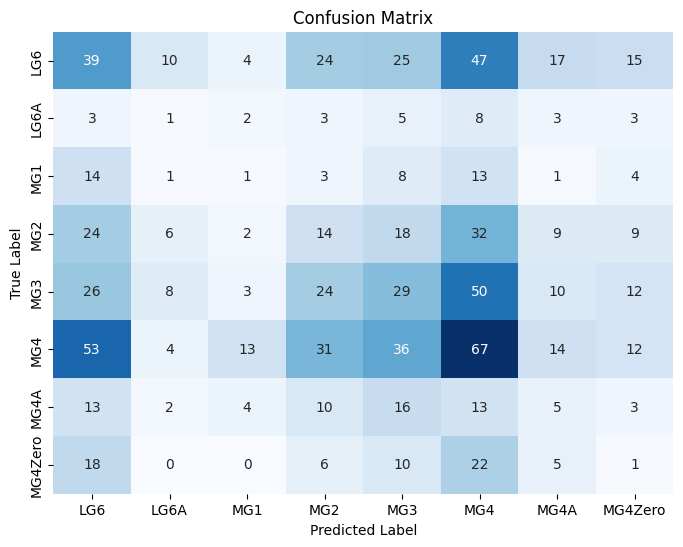

In [111]:
accuracy_train_dummy = accuracy_mx_report(y_true = y_train, y_pred = y_pred_train_dummy, model = dummy_clf)


Classification Report:
              precision    recall  f1-score   support

         LG6       0.33      0.32      0.33        22
        LG6A       0.00      0.00      0.00         3
         MG1       0.00      0.00      0.00         6
         MG2       0.07      0.07      0.07        14
         MG3       0.17      0.15      0.16        20
         MG4       0.16      0.17      0.17        29
        MG4A       0.10      0.11      0.11         9
     MG4Zero       0.00      0.00      0.00         8

    accuracy                           0.15       111
   macro avg       0.10      0.10      0.10       111
weighted avg       0.16      0.15      0.15       111

Confusion Matrix of DummyClassifier(strategy='stratified') Method and Accuracy Score Report:

Accuracy: 15.32% 



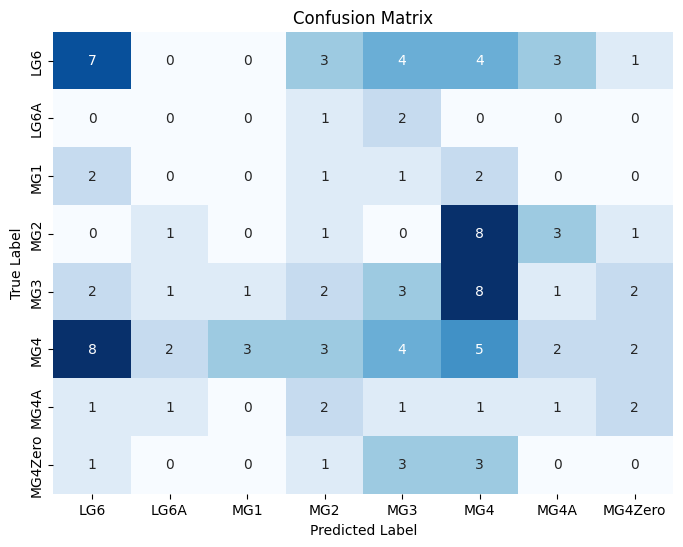

In [112]:
accuracy_valid_dummy = accuracy_mx_report(y_true = y_valid, y_pred = y_pred_valid_dummy, model = dummy_clf)


Classification Report:
              precision    recall  f1-score   support

         LG6       0.12      0.13      0.12        23
        LG6A       0.50      0.25      0.33         4
         MG1       0.00      0.00      0.00         5
         MG2       0.05      0.07      0.06        14
         MG3       0.22      0.24      0.23        21
         MG4       0.30      0.24      0.27        29
        MG4A       0.00      0.00      0.00         8
     MG4Zero       0.00      0.00      0.00         7

    accuracy                           0.15       111
   macro avg       0.15      0.12      0.13       111
weighted avg       0.17      0.15      0.16       111

Confusion Matrix of DummyClassifier(strategy='stratified') Method and Accuracy Score Report:

Accuracy: 15.32% 



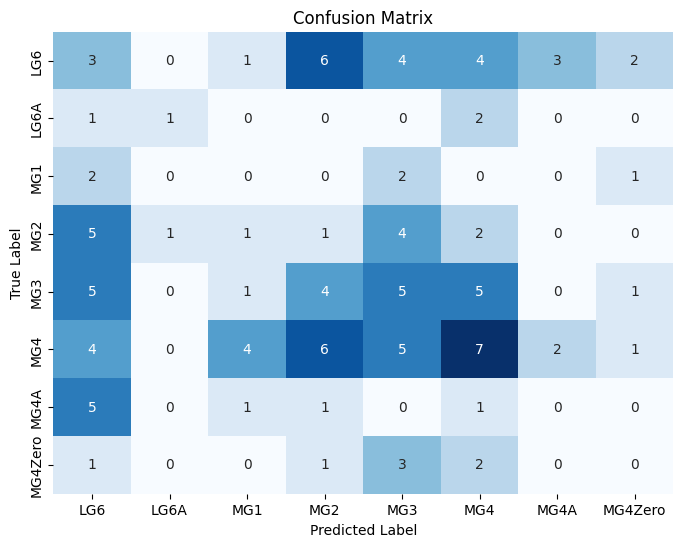

In [113]:
accuracy_test_dummy = accuracy_mx_report(y_true = y_test, y_pred = y_pred_test_dummy, model = dummy_clf)

- cari probability muncul masing-masing kelas
- cari proporsi muncul masing-masing kelas di data training
- car total odds munculnya kelas berdasarkan prior probability tersebut

---
### **1. Random Forest Method**

Random Forest Classification Model (Default)

In [114]:
# For RF and DT, we use encoded y_true data
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Apply label encoding to the target variable
y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.transform(y_valid)
y_test_encoded = le.transform(y_test)

In [115]:
from sklearn.ensemble import RandomForestClassifier
model_rf1 = RandomForestClassifier(random_state=42, class_weight='balanced')
model_rf1.fit(X_train_cleaned, y_train_encoded)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [116]:
y_pred_train_rf = model_rf1.predict(X_train_cleaned)
y_pred_valid_rf = model_rf1.predict(X_valid_cleaned)
y_pred_test_rf = model_rf1.predict(X_test_cleaned)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       181
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        45
           3       1.00      1.00      1.00       114
           4       1.00      1.00      1.00       162
           5       1.00      1.00      1.00       230
           6       1.00      1.00      1.00        66
           7       1.00      1.00      1.00        62

    accuracy                           1.00       888
   macro avg       1.00      1.00      1.00       888
weighted avg       1.00      1.00      1.00       888

Confusion Matrix of RandomForestClassifier(class_weight='balanced', random_state=42) Method and Accuracy Score Report:

Accuracy: 100.00% 



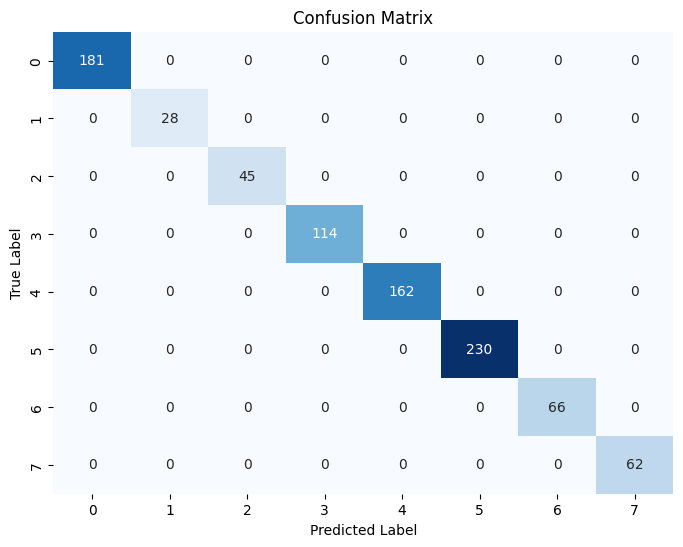

In [117]:
accuracy_rf_train = accuracy_mx_report(y_true = y_train_encoded, y_pred = y_pred_train_rf, model = model_rf1)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      0.67      0.80         3
           2       0.75      0.50      0.60         6
           3       0.64      0.50      0.56        14
           4       0.54      0.65      0.59        20
           5       0.61      0.69      0.65        29
           6       1.00      0.56      0.71         9
           7       0.38      0.38      0.38         8

    accuracy                           0.68       111
   macro avg       0.73      0.62      0.66       111
weighted avg       0.69      0.68      0.67       111

Confusion Matrix of RandomForestClassifier(class_weight='balanced', random_state=42) Method and Accuracy Score Report:

Accuracy: 67.57% 



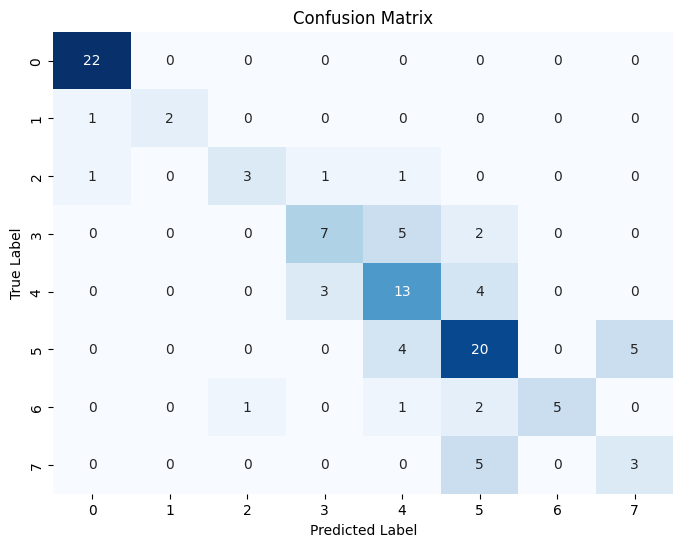

In [118]:
accuracy_rf_valid = accuracy_mx_report(y_true = y_valid_encoded, y_pred = y_pred_valid_rf, model = model_rf1)


Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        23
           1       1.00      0.50      0.67         4
           2       1.00      0.80      0.89         5
           3       0.83      0.71      0.77        14
           4       0.79      0.71      0.75        21
           5       0.54      0.72      0.62        29
           6       0.33      0.25      0.29         8
           7       0.67      0.29      0.40         7

    accuracy                           0.71       111
   macro avg       0.76      0.62      0.66       111
weighted avg       0.73      0.71      0.70       111

Confusion Matrix of RandomForestClassifier(class_weight='balanced', random_state=42) Method and Accuracy Score Report:

Accuracy: 71.17% 



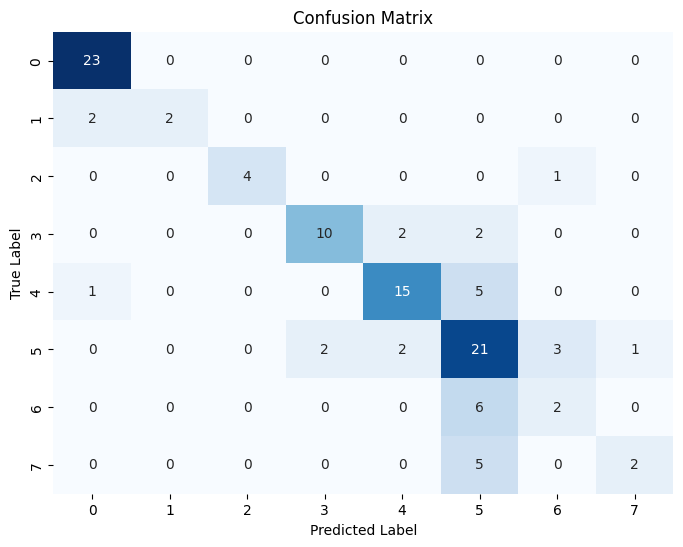

In [119]:
accuracy_rf_test = accuracy_mx_report(y_true = y_test_encoded, y_pred = y_pred_test_rf, model = model_rf1)

---
### **2. Decision Tree Classification Model (Bagged)**

Declaring Label Binarizer for bagging purposes (to read target with number variable), if target can't difference string

In [120]:
# For Bagging, we use encoded y_true data
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Apply label encoding to the target variable
y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.transform(y_valid)
y_test_encoded = le.transform(y_test)

In [121]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Bagging - Decision Tree Model
B = [10, 20, 50, 70, 100, 120, 150]
params = {"n_estimators": B}

# Buat gridsearch
dt = DecisionTreeClassifier()
bagging_tree = BaggingClassifier(estimator = dt,
                                random_state = 123)

bagging_cv = GridSearchCV(estimator = bagging_tree,
                          param_grid = params,
                          cv = 5,
                          scoring = "accuracy")

In [122]:
# Fit grid search cv
bagging_cv.fit(X_train_cleaned, y_train_encoded)

# Best params
bagging_cv.best_params_

{'n_estimators': 70}

In [123]:
# Refit the bagging tree
bagging_tree = BaggingClassifier(n_estimators = bagging_cv.best_params_["n_estimators"],
                                random_state = 123)

model_bgt = bagging_tree.fit(X_train_cleaned, y_train_encoded)
model_bgt

BaggingClassifier(n_estimators=70, random_state=123)

In [124]:
# make y_pred

y_pred_bgd_train = model_bgt.predict(X_train_cleaned)
y_pred_bgd_valid = model_bgt.predict(X_valid_cleaned)
y_pred_bgd_test = model_bgt.predict(X_test_cleaned)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       181
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        45
           3       1.00      1.00      1.00       114
           4       1.00      1.00      1.00       162
           5       1.00      1.00      1.00       230
           6       1.00      1.00      1.00        66
           7       1.00      1.00      1.00        62

    accuracy                           1.00       888
   macro avg       1.00      1.00      1.00       888
weighted avg       1.00      1.00      1.00       888

Confusion Matrix of BaggingClassifier(n_estimators=70, random_state=123) Method and Accuracy Score Report:

Accuracy: 100.00% 



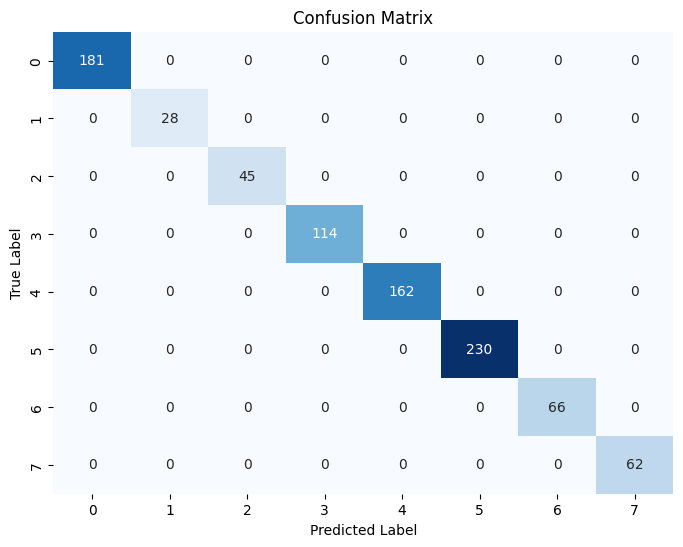

In [125]:
accuracy_dt_train = accuracy_mx_report(y_true = y_train_encoded, y_pred = y_pred_bgd_train, model = model_bgt)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       1.00      1.00      1.00         3
           2       0.83      0.83      0.83         6
           3       0.67      0.57      0.62        14
           4       0.69      0.55      0.61        20
           5       0.54      0.66      0.59        29
           6       0.80      0.44      0.57         9
           7       0.42      0.62      0.50         8

    accuracy                           0.68       111
   macro avg       0.74      0.70      0.71       111
weighted avg       0.71      0.68      0.69       111

Confusion Matrix of BaggingClassifier(n_estimators=70, random_state=123) Method and Accuracy Score Report:

Accuracy: 68.47% 



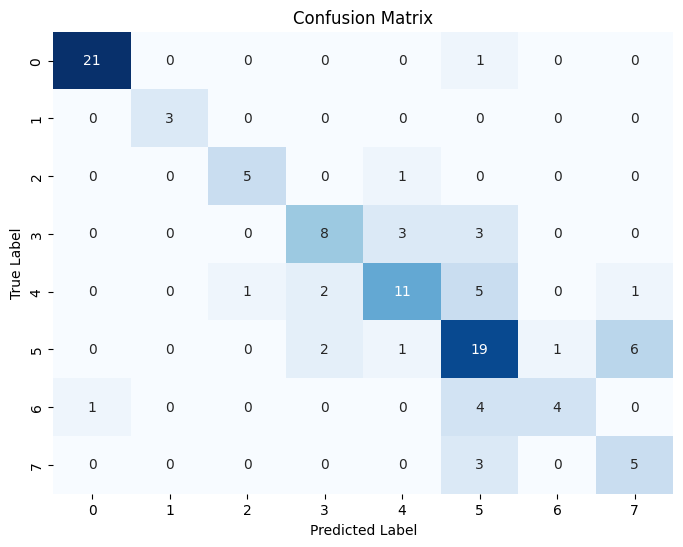

In [126]:
accuracy_dt_valid = accuracy_mx_report(y_true = y_valid_encoded, y_pred = y_pred_bgd_valid, model = model_bgt)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       0.75      0.75      0.75         4
           2       1.00      0.40      0.57         5
           3       0.77      0.71      0.74        14
           4       0.78      0.86      0.82        21
           5       0.68      0.66      0.67        29
           6       0.33      0.38      0.35         8
           7       0.86      0.86      0.86         7

    accuracy                           0.76       111
   macro avg       0.76      0.70      0.71       111
weighted avg       0.76      0.76      0.75       111

Confusion Matrix of BaggingClassifier(n_estimators=70, random_state=123) Method and Accuracy Score Report:

Accuracy: 75.68% 



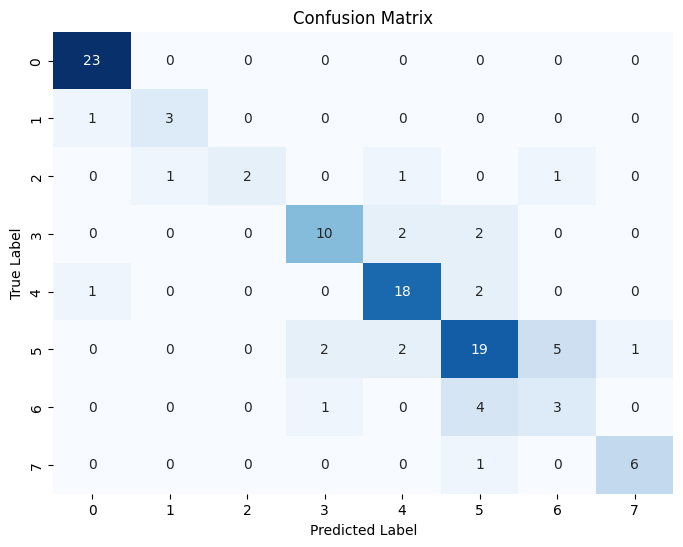

In [127]:
accuracy_dt_test = accuracy_mx_report(y_true = y_test_encoded, y_pred = y_pred_bgd_test, model = model_bgt)

---
### **3. Multinomial Logistic Regression**

Multinomial Logistic Regression Model

In [128]:
mlr = LogisticRegression(random_state=0,
                         multi_class='multinomial',
                         class_weight = dict(class_weight),
                         solver='newton-cg')

model_mlr = mlr.fit(X_train_cleaned, y_train)

y_train_pred_mlr = model_mlr.predict(X_train_cleaned)
y_valid_pred_mlr = model_mlr.predict(X_valid_cleaned)
y_test_pred_mlr = model_mlr.predict(X_test_cleaned)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [129]:
# print the tunable parameters (They were not tuned in this example, everything kept as default)
params = model_mlr.get_params()
print(params)

{'C': 1.0, 'class_weight': {}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [130]:
# Experimentation a bit with GridSearchCV with fitting the data

search_params = {"penalty": ['l2', None],
                 "C": [0.2,0.4,0,6,0.8,1,2,3]}

mlr_cv = GridSearchCV(estimator = model_mlr,
                      param_grid = search_params,
                      cv = 5)

# Data Fitting
mlr_cv.fit(X = X_train_scaled,
           y = y_train)

# Best params
mlr_cv.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and

{'C': 6, 'penalty': 'l2'}

In [131]:
# Create best model
mlr_best = LogisticRegression(multi_class='multinomial',
                                penalty = mlr_cv.best_params_["penalty"],
                                C = mlr_cv.best_params_["C"],
                                solver = 'newton-cg',
                                random_state = 0)

model_mlr = mlr_best.fit(X_train_cleaned, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [132]:
# output y_pred model multinomial logreg

y_train_pred_mlr = model_mlr.predict(X_train_cleaned)
y_valid_pred_mlr = model_mlr.predict(X_valid_cleaned)
y_test_pred_mlr = model_mlr.predict(X_test_cleaned)

params = model_mlr.get_params()
print(params)

{'C': 6, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}



Classification Report:
              precision    recall  f1-score   support

         LG6       1.00      1.00      1.00       181
        LG6A       1.00      1.00      1.00        28
         MG1       1.00      1.00      1.00        45
         MG2       1.00      0.98      0.99       114
         MG3       0.98      0.99      0.98       162
         MG4       0.98      0.98      0.98       230
        MG4A       0.97      0.97      0.97        66
     MG4Zero       1.00      1.00      1.00        62

    accuracy                           0.99       888
   macro avg       0.99      0.99      0.99       888
weighted avg       0.99      0.99      0.99       888

Confusion Matrix of LogisticRegression(C=6, multi_class='multinomial', random_state=0,
                   solver='newton-cg') Method and Accuracy Score Report:

Accuracy: 98.76% 



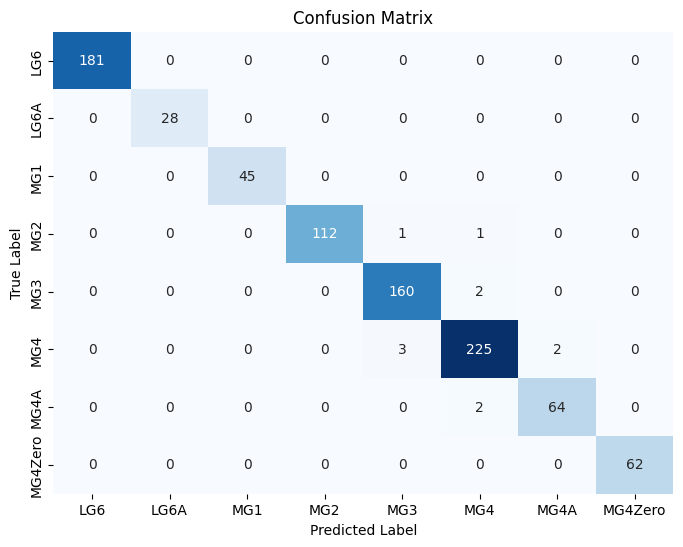

In [133]:
accuracy_mlr_train = accuracy_mx_report(y_true = y_train, y_pred = y_train_pred_mlr, model = model_mlr)


Classification Report:
              precision    recall  f1-score   support

         LG6       1.00      1.00      1.00        22
        LG6A       0.75      1.00      0.86         3
         MG1       0.60      0.50      0.55         6
         MG2       0.64      0.50      0.56        14
         MG3       0.67      0.60      0.63        20
         MG4       0.53      0.66      0.58        29
        MG4A       0.40      0.44      0.42         9
     MG4Zero       0.60      0.38      0.46         8

    accuracy                           0.66       111
   macro avg       0.65      0.63      0.63       111
weighted avg       0.66      0.66      0.66       111

Confusion Matrix of LogisticRegression(C=6, multi_class='multinomial', random_state=0,
                   solver='newton-cg') Method and Accuracy Score Report:

Accuracy: 65.77% 



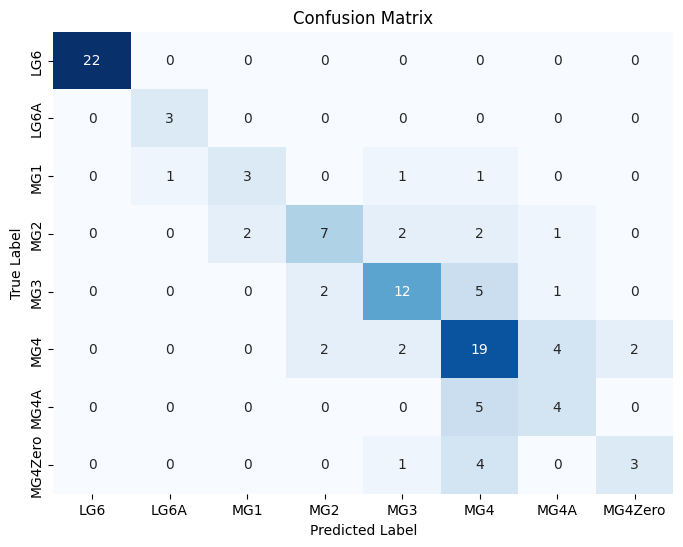

In [134]:
accuracy_mlr_valid = accuracy_mx_report(y_true = y_valid, y_pred = y_valid_pred_mlr, model = model_mlr)


Classification Report:
              precision    recall  f1-score   support

         LG6       1.00      0.91      0.95        23
        LG6A       0.60      0.75      0.67         4
         MG1       0.83      1.00      0.91         5
         MG2       0.79      0.79      0.79        14
         MG3       0.84      0.76      0.80        21
         MG4       0.66      0.72      0.69        29
        MG4A       0.44      0.50      0.47         8
     MG4Zero       0.60      0.43      0.50         7

    accuracy                           0.76       111
   macro avg       0.72      0.73      0.72       111
weighted avg       0.77      0.76      0.76       111

Confusion Matrix of LogisticRegression(C=6, multi_class='multinomial', random_state=0,
                   solver='newton-cg') Method and Accuracy Score Report:

Accuracy: 75.68% 



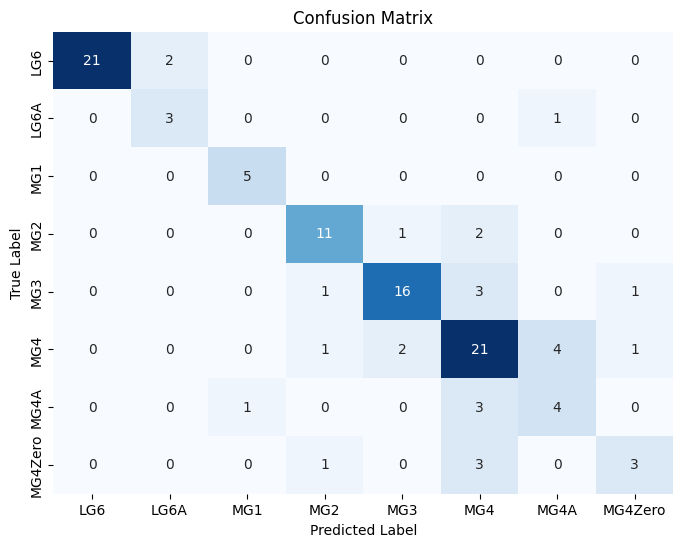

In [135]:
accuracy_mlr_test = accuracy_mx_report(y_true = y_test, y_pred = y_test_pred_mlr, model = model_mlr)

In [136]:
# Print model parameters (save it for later)
print('Intercept: \n', model_mlr.intercept_)
print('Coefficients: \n', model_mlr.coef_)

# array for coefficients (save it for later)
np.exp(model_mlr.coef_)

Intercept: 
 [-33.08984328   5.49224214  -7.80745824  29.30291293  35.96461709
   9.14031727 -53.16561257  14.16282466]
Coefficients: 
 [[ 5.79758434e-01  3.26521214e-03 -1.16358298e-03 ... -6.06285247e-02
   5.28553823e-01 -1.96863080e+00]
 [ 5.44662469e-01 -1.71559671e-03 -4.40348673e-04 ...  4.83808711e-01
  -9.60756450e-01 -1.67175969e+00]
 [-9.00684740e-01 -1.98868049e-03 -1.27560484e-02 ...  6.61135451e-01
  -8.70431232e-01  8.70401666e-01]
 ...
 [ 8.54566755e-01 -3.62727660e-04 -1.25946163e-01 ... -2.75528575e+00
   1.57775828e+00 -1.15071334e-01]
 [-5.21634518e-01 -9.73407423e-06 -1.78360042e-02 ... -1.41950243e+00
   3.00721453e+00 -1.45869551e+00]
 [-6.62154113e-01 -2.98104377e-04 -1.19329689e-02 ...  2.03362913e+00
  -4.60205268e+00  3.43606594e+00]]


array([[1.78560704e+00, 1.00327055e+00, 9.98837094e-01, ...,
        9.41172797e-01, 1.69647713e+00, 1.39647932e-01],
       [1.72402637e+00, 9.98285874e-01, 9.99559748e-01, ...,
        1.62224130e+00, 3.82603356e-01, 1.87916100e-01],
       [4.06291361e-01, 9.98013296e-01, 9.87324965e-01, ...,
        1.93699044e+00, 4.18770923e-01, 2.38786979e+00],
       ...,
       [2.35035588e+00, 9.99637338e-01, 8.81662311e-01, ...,
        6.35908458e-02, 4.84408454e+00, 8.91302561e-01],
       [5.93549587e-01, 9.99990266e-01, 9.82322116e-01, ...,
        2.41834317e-01, 2.02309687e+01, 2.32539422e-01],
       [5.15739176e-01, 9.99701940e-01, 9.88137947e-01, ...,
        7.64176904e+00, 1.00312237e-02, 3.10645079e+01]])

---
### **4. LDA Classification (Paper)**

In [137]:
# using default solver (svd)
lda_model1 = LinearDiscriminantAnalysis (n_components = 7)

lda_train = lda_model1.fit_transform(X_train_cleaned, y_train)
lda_valid  = lda_model1.transform(X_valid_cleaned)
lda_test = lda_model1.transform(X_test_cleaned)

The `lsqr` (Least Square) solver is an efficient algorithm that only works for classification

source: https://scikit-learn.org/stable/modules/lda_qda.html, **Section 1.2.5**

In [138]:
# dengan menggunakan solver lsqr
lda_model2 = LinearDiscriminantAnalysis (n_components = 7, solver='lsqr', shrinkage=None).fit(X_train_cleaned, y_train)

In [139]:
# making y_pred on model 1

y_pred_lda1_train = lda_model1.predict(X_train_cleaned)
y_pred_lda1_valid = lda_model1.predict(X_valid_cleaned)
y_pred_lda1_test = lda_model1.predict(X_test_cleaned)

In [140]:
# making y_pred on model 2

y_pred_lda2_train = lda_model2.predict(X_train_cleaned)
y_pred_lda2_valid = lda_model2.predict(X_valid_cleaned)
y_pred_lda2_test = lda_model2.predict(X_test_cleaned)


Classification Report:
              precision    recall  f1-score   support

         LG6       1.00      0.99      1.00       181
        LG6A       0.97      1.00      0.98        28
         MG1       0.98      0.93      0.95        45
         MG2       0.96      0.96      0.96       114
         MG3       0.95      0.99      0.97       162
         MG4       0.97      0.97      0.97       230
        MG4A       0.97      0.88      0.92        66
     MG4Zero       0.98      0.98      0.98        62

    accuracy                           0.97       888
   macro avg       0.97      0.96      0.97       888
weighted avg       0.97      0.97      0.97       888

Confusion Matrix of LinearDiscriminantAnalysis(n_components=7, solver='lsqr') Method and Accuracy Score Report:

Accuracy: 97.07% 



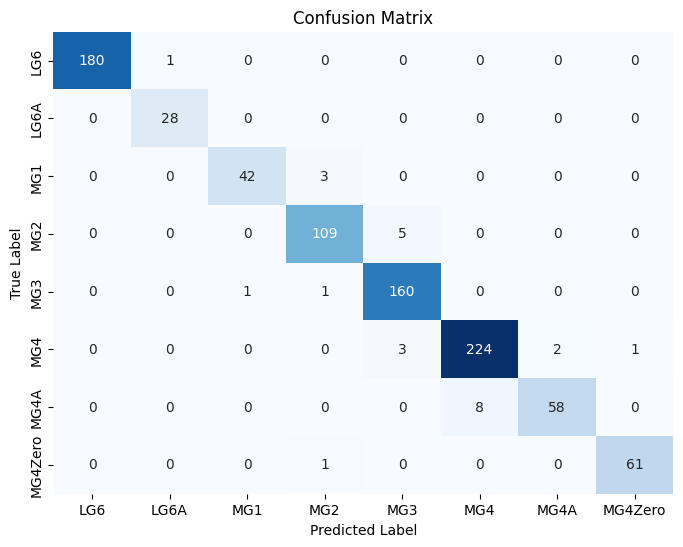

In [141]:
accuracy_lda_train = accuracy_mx_report(y_true = y_train, y_pred = y_pred_lda2_train, model = lda_model2)


Classification Report:
              precision    recall  f1-score   support

         LG6       1.00      0.82      0.90        22
        LG6A       0.67      0.67      0.67         3
         MG1       0.38      0.83      0.53         6
         MG2       0.70      0.50      0.58        14
         MG3       0.65      0.75      0.70        20
         MG4       0.77      0.79      0.78        29
        MG4A       0.86      0.67      0.75         9
     MG4Zero       0.86      0.75      0.80         8

    accuracy                           0.74       111
   macro avg       0.74      0.72      0.71       111
weighted avg       0.77      0.74      0.75       111

Confusion Matrix of LinearDiscriminantAnalysis(n_components=7) Method and Accuracy Score Report:

Accuracy: 73.87% 



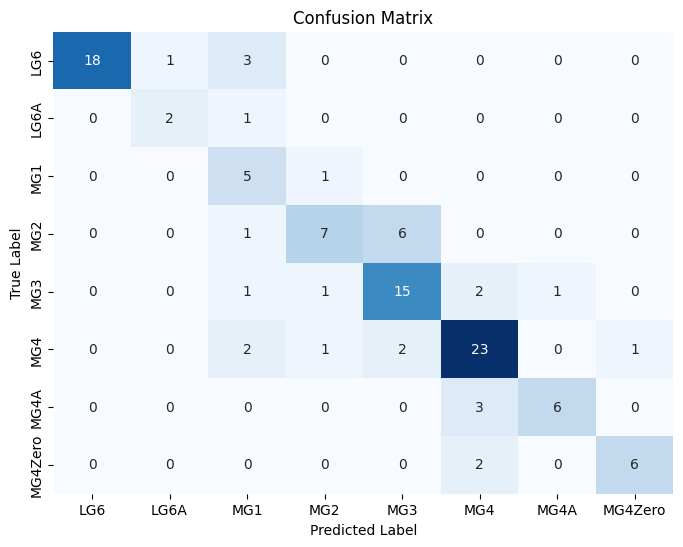

0.7387387387387387

In [142]:
accuracy_mx_report(y_true = y_valid, y_pred = y_pred_lda1_valid, model = lda_model1)


Classification Report:
              precision    recall  f1-score   support

         LG6       0.95      0.82      0.88        22
        LG6A       0.43      1.00      0.60         3
         MG1       0.43      0.50      0.46         6
         MG2       0.50      0.43      0.46        14
         MG3       0.68      0.75      0.71        20
         MG4       0.73      0.83      0.77        29
        MG4A       1.00      0.56      0.71         9
     MG4Zero       0.83      0.62      0.71         8

    accuracy                           0.71       111
   macro avg       0.69      0.69      0.66       111
weighted avg       0.74      0.71      0.71       111

Confusion Matrix of LinearDiscriminantAnalysis(n_components=7, solver='lsqr') Method and Accuracy Score Report:

Accuracy: 71.17% 



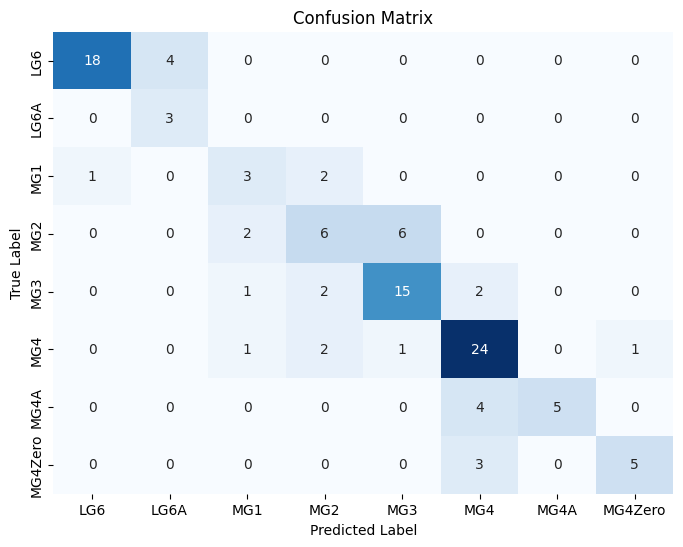

In [143]:
accuracy_lda_valid = accuracy_mx_report(y_true = y_valid, y_pred = y_pred_lda2_valid, model = lda_model2)


Classification Report:
              precision    recall  f1-score   support

         LG6       0.94      0.74      0.83        23
        LG6A       0.33      0.50      0.40         4
         MG1       0.50      0.60      0.55         5
         MG2       0.55      0.79      0.65        14
         MG3       0.75      0.71      0.73        21
         MG4       0.65      0.52      0.58        29
        MG4A       0.29      0.25      0.27         8
     MG4Zero       0.55      0.86      0.67         7

    accuracy                           0.64       111
   macro avg       0.57      0.62      0.58       111
weighted avg       0.67      0.64      0.64       111

Confusion Matrix of LinearDiscriminantAnalysis(n_components=7) Method and Accuracy Score Report:

Accuracy: 63.96% 



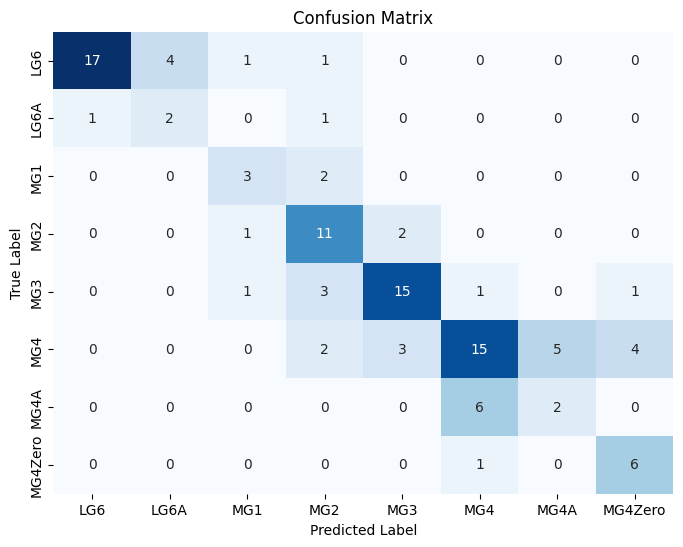

0.6396396396396397

In [144]:
accuracy_mx_report(y_true = y_test, y_pred = y_pred_lda1_test, model = lda_model1)


Classification Report:
              precision    recall  f1-score   support

         LG6       0.94      0.74      0.83        23
        LG6A       0.38      0.75      0.50         4
         MG1       0.75      0.60      0.67         5
         MG2       0.64      1.00      0.78        14
         MG3       0.89      0.76      0.82        21
         MG4       0.68      0.59      0.63        29
        MG4A       0.29      0.25      0.27         8
     MG4Zero       0.56      0.71      0.63         7

    accuracy                           0.69       111
   macro avg       0.64      0.68      0.64       111
weighted avg       0.72      0.69      0.70       111

Confusion Matrix of LinearDiscriminantAnalysis(n_components=7, solver='lsqr') Method and Accuracy Score Report:

Accuracy: 69.37% 



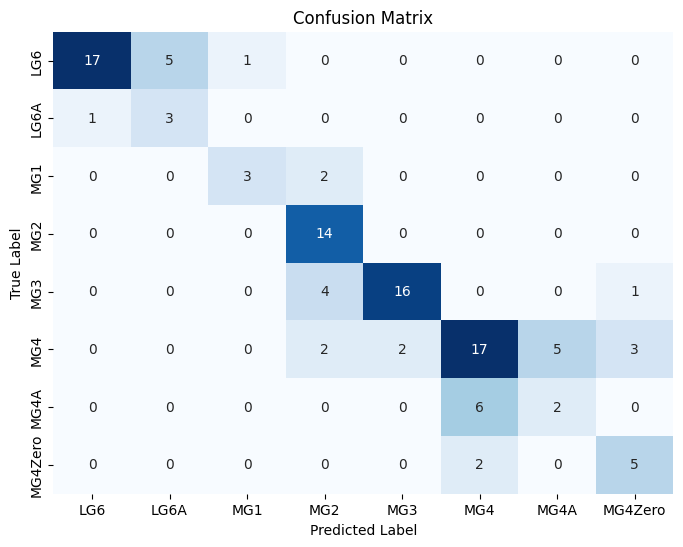

In [145]:
accuracy_lda_test = accuracy_mx_report(y_true = y_test, y_pred = y_pred_lda2_test, model = lda_model2)

---
**Kesimpulan**

Bisa diambil 4 model teratas (di atas 65 persen), untuk score accuracy nya, secara kasar (Belum detail):

- 1. Multinomial Logistic Regression
- 2. Random Forest Classifier
- 3. Decision Tree Classifier with Bagging
- 4. LDA (Linear Discriminant Analysis) with Least Square Solver

---
### 5. Optimize the Model (with Neural Network and SGD)

later to be updated

Kita akan rangkum informasi perihal akurasi tiap model untuk selanjutnya dievaluasi dan mencari model mana yang terbaik,
secara overall parameter yang ada

# Model Visualization, Evaluation, and Explanation


**Summary**

From Paper (See Table 6)

![Screenshot 2024-09-15 043414.png](attachment:553d6c2e-daa5-4d84-9f4f-04425d906fbd.png)

Cross-check to our confusion matrix (but this time we will use only data valid and data test as our main ground

---
**Model Visualization - Multinomial Logistic Regression**


In [146]:
# Print model parameters
print('Intercept: \n', model_mlr.intercept_)
print('Coefficients: \n', model_mlr.coef_)

Intercept: 
 [-33.08984328   5.49224214  -7.80745824  29.30291293  35.96461709
   9.14031727 -53.16561257  14.16282466]
Coefficients: 
 [[ 5.79758434e-01  3.26521214e-03 -1.16358298e-03 ... -6.06285247e-02
   5.28553823e-01 -1.96863080e+00]
 [ 5.44662469e-01 -1.71559671e-03 -4.40348673e-04 ...  4.83808711e-01
  -9.60756450e-01 -1.67175969e+00]
 [-9.00684740e-01 -1.98868049e-03 -1.27560484e-02 ...  6.61135451e-01
  -8.70431232e-01  8.70401666e-01]
 ...
 [ 8.54566755e-01 -3.62727660e-04 -1.25946163e-01 ... -2.75528575e+00
   1.57775828e+00 -1.15071334e-01]
 [-5.21634518e-01 -9.73407423e-06 -1.78360042e-02 ... -1.41950243e+00
   3.00721453e+00 -1.45869551e+00]
 [-6.62154113e-01 -2.98104377e-04 -1.19329689e-02 ...  2.03362913e+00
  -4.60205268e+00  3.43606594e+00]]


In [147]:
np.exp(model_mlr.coef_)

array([[1.78560704e+00, 1.00327055e+00, 9.98837094e-01, ...,
        9.41172797e-01, 1.69647713e+00, 1.39647932e-01],
       [1.72402637e+00, 9.98285874e-01, 9.99559748e-01, ...,
        1.62224130e+00, 3.82603356e-01, 1.87916100e-01],
       [4.06291361e-01, 9.98013296e-01, 9.87324965e-01, ...,
        1.93699044e+00, 4.18770923e-01, 2.38786979e+00],
       ...,
       [2.35035588e+00, 9.99637338e-01, 8.81662311e-01, ...,
        6.35908458e-02, 4.84408454e+00, 8.91302561e-01],
       [5.93549587e-01, 9.99990266e-01, 9.82322116e-01, ...,
        2.41834317e-01, 2.02309687e+01, 2.32539422e-01],
       [5.15739176e-01, 9.99701940e-01, 9.88137947e-01, ...,
        7.64176904e+00, 1.00312237e-02, 3.10645079e+01]])

In [148]:
# Declare y_pred_proba on train data
y_pred_trainproba_rf = model_rf1.predict_proba(X_train_cleaned)
y_pred_trainproba_bgt = model_bgt.predict_proba(X_train_cleaned)
y_pred_trainproba_mlr = model_mlr.predict_proba(X_train_cleaned)
y_pred_trainproba_lda = lda_model2.predict_proba(X_train_cleaned)

In [149]:
# Declare y_pred_proba on valid data
y_pred_validproba_rf = model_rf1.predict_proba(X_valid_cleaned)
y_pred_validproba_bgt = model_bgt.predict_proba(X_valid_cleaned)
y_pred_validproba_mlr = model_mlr.predict_proba(X_valid_cleaned)
y_pred_validproba_lda = lda_model2.predict_proba(X_valid_cleaned)

In [150]:
# Declare y_pred_proba on test data
y_pred_testproba_rf = model_rf1.predict_proba(X_test_cleaned)
y_pred_testproba_bgt = model_bgt.predict_proba(X_test_cleaned)
y_pred_testproba_mlr = model_mlr.predict_proba(X_test_cleaned)
y_pred_testproba_lda = lda_model2.predict_proba(X_test_cleaned)

In [151]:
# Calculate log loss train
log_loss_trainrf = log_loss(y_train_encoded, y_pred_trainproba_rf)
log_loss_trainbgt = log_loss(y_train_encoded, y_pred_trainproba_bgt)
log_loss_trainmlr = log_loss(y_train, y_pred_trainproba_mlr)
log_loss_trainlda = log_loss(y_train, y_pred_trainproba_lda)

In [152]:
# Calculate log loss valid
log_loss_validrf = log_loss(y_valid_encoded, y_pred_validproba_rf)
log_loss_validbgt = log_loss(y_valid_encoded, y_pred_validproba_bgt)
log_loss_validmlr = log_loss(y_valid, y_pred_validproba_mlr)
log_loss_validlda = log_loss(y_valid, y_pred_validproba_lda)

In [153]:
# Calculate log loss test
log_loss_testrf = log_loss(y_test_encoded, y_pred_testproba_rf)
log_loss_testbgt = log_loss(y_test_encoded, y_pred_testproba_bgt)
log_loss_testmlr = log_loss(y_test, y_pred_testproba_mlr)
log_loss_testlda = log_loss(y_test, y_pred_testproba_lda)

**Creating Report DataFrame**

In [154]:
accuracy_train = [accuracy_train_dummy, accuracy_rf_train, accuracy_dt_train, accuracy_mlr_train, accuracy_lda_train]
accuracy_valid = [accuracy_valid_dummy, accuracy_rf_valid, accuracy_dt_valid, accuracy_mlr_valid, accuracy_lda_valid]
accuracy_test = [accuracy_test_dummy, accuracy_rf_test, accuracy_dt_test, accuracy_mlr_test, accuracy_lda_test]
log_loss_train = [0.0, log_loss_trainrf, log_loss_trainbgt, log_loss_trainmlr, log_loss_trainlda]
log_loss_valid = [0.0, log_loss_validrf, log_loss_validbgt, log_loss_validmlr, log_loss_validlda]
log_loss_test = [0.0, log_loss_testrf, log_loss_testbgt, log_loss_testmlr, log_loss_testlda]
indexes = ["dummy classifier","random forest", "bagged decision tree","multinomial logistic regression", "linear discriminant"]

summary_df = pd.DataFrame({"Accuracy Train Report":accuracy_train,
                           "Accuracy Valid Report":accuracy_valid,
                           "Accuracy Test Report": accuracy_test,
                           "Log Loss Train Report": log_loss_train,
                           "Log Loss Valid Report": log_loss_valid,
                           "Log Loss Test Report": log_loss_test},
                          index = indexes)
summary_df

,Accuracy Train Report,Accuracy Valid Report,Accuracy Test Report,Log Loss Train Report,Log Loss Valid Report,Log Loss Test Report
dummy classifier,0.176802,0.153153,0.153153,0.000000,0.000000,0.000000
random forest,1.000000,0.675676,0.711712,0.200382,0.974608,0.812507
bagged decision tree,1.000000,0.684685,0.756757,0.147630,1.813571,0.631634
multinomial logistic regression,0.987613,0.657658,0.756757,0.134002,1.106885,0.870445
linear discriminant,0.970721,0.711712,0.693694,0.166693,3.471218,4.615486


In [155]:
summary_df['accuracy_gap'] = (summary_df['Accuracy Valid Report'] - summary_df['Accuracy Train Report']).abs()
summary_df['accuracy_ratio'] = (summary_df['Accuracy Valid Report'] / summary_df['Accuracy Train Report'])
summary_df['log_loss gap'] = (summary_df['Log Loss Valid Report'] - summary_df['Log Loss Train Report']).abs()
summary_df['log_loss ratio'] = (summary_df['Log Loss Valid Report'] / summary_df['Log Loss Train Report'])

In [156]:
summary_df_ok = summary_df.drop(index=('dummy classifier'))

In [157]:
summary_df_ok

,Accuracy Train Report,Accuracy Valid Report,Accuracy Test Report,Log Loss Train Report,Log Loss Valid Report,Log Loss Test Report,accuracy_gap,accuracy_ratio,log_loss gap,log_loss ratio
random forest,1.000000,0.675676,0.711712,0.200382,0.974608,0.812507,0.324324,0.675676,0.774226,4.863752
bagged decision tree,1.000000,0.684685,0.756757,0.147630,1.813571,0.631634,0.315315,0.684685,1.665941,12.284534
multinomial logistic regression,0.987613,0.657658,0.756757,0.134002,1.106885,0.870445,0.329955,0.665906,0.972883,8.260204
linear discriminant,0.970721,0.711712,0.693694,0.166693,3.471218,4.615486,0.259009,0.733179,3.304525,20.824026


In [158]:
min_index = summary_df_ok['accuracy_gap'].idxmin()
min_row = summary_df_ok.loc[min_index]
print('accuracy gap minimum:','\n' ,min_row)

accuracy gap minimum: 
 Accuracy Train Report     0.970721
Accuracy Valid Report     0.711712
Accuracy Test Report      0.693694
Log Loss Train Report     0.166693
Log Loss Valid Report     3.471218
Log Loss Test Report      4.615486
accuracy_gap              0.259009
accuracy_ratio            0.733179
log_loss gap              3.304525
log_loss ratio           20.824026
Name: linear discriminant, dtype: float64


In [159]:
min_index = summary_df_ok['log_loss gap'].idxmin()
min_row = summary_df_ok.loc[min_index]
print('log loss gap minimum:','\n' ,min_row)

log loss gap minimum: 
 Accuracy Train Report    1.000000
Accuracy Valid Report    0.675676
Accuracy Test Report     0.711712
Log Loss Train Report    0.200382
Log Loss Valid Report    0.974608
Log Loss Test Report     0.812507
accuracy_gap             0.324324
accuracy_ratio           0.675676
log_loss gap             0.774226
log_loss ratio           4.863752
Name: random forest, dtype: float64


Terlihat bahwa baik LDA (yang digunakan di paper) memiliki keunggulan tersendiri di sektor akurasi,
sementara MLR unggul di metrik logarithmic loss (Cross Entropy Loss)

---
**Persiapan Visualisasi**

In [160]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(111, 8)

In [161]:
class_of_interest = ["LG6", "LG6A", "MG1", "MG2", "MG3", "MG4", "MG4A", "MG4Zero"]
label_binarizer.transform(["LG6", "LG6A", "MG1", "MG2", "MG3", "MG4", "MG4A", "MG4Zero"])
y_onehot_test = label_binarizer.fit_transform(y_test)

---
### Visualisasi Hasil - MLR

In [162]:
n_classes = len(class_of_interest)
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_testproba_mlr.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.95


In [163]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_pred_testproba_mlr,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.95


In [164]:
from itertools import combinations

pair_list = list(combinations(np.unique(y), 2))
print(pair_list)

[('LG6', 'LG6A'), ('LG6', 'MG1'), ('LG6', 'MG2'), ('LG6', 'MG3'), ('LG6', 'MG4'), ('LG6', 'MG4A'), ('LG6', 'MG4Zero'), ('LG6A', 'MG1'), ('LG6A', 'MG2'), ('LG6A', 'MG3'), ('LG6A', 'MG4'), ('LG6A', 'MG4A'), ('LG6A', 'MG4Zero'), ('MG1', 'MG2'), ('MG1', 'MG3'), ('MG1', 'MG4'), ('MG1', 'MG4A'), ('MG1', 'MG4Zero'), ('MG2', 'MG3'), ('MG2', 'MG4'), ('MG2', 'MG4A'), ('MG2', 'MG4Zero'), ('MG3', 'MG4'), ('MG3', 'MG4A'), ('MG3', 'MG4Zero'), ('MG4', 'MG4A'), ('MG4', 'MG4Zero'), ('MG4A', 'MG4Zero')]


Visualize ROC-AUC Curve multi-class curve

In [165]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_testproba_mlr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.95


Visualize ROC-AUC multi-class curve

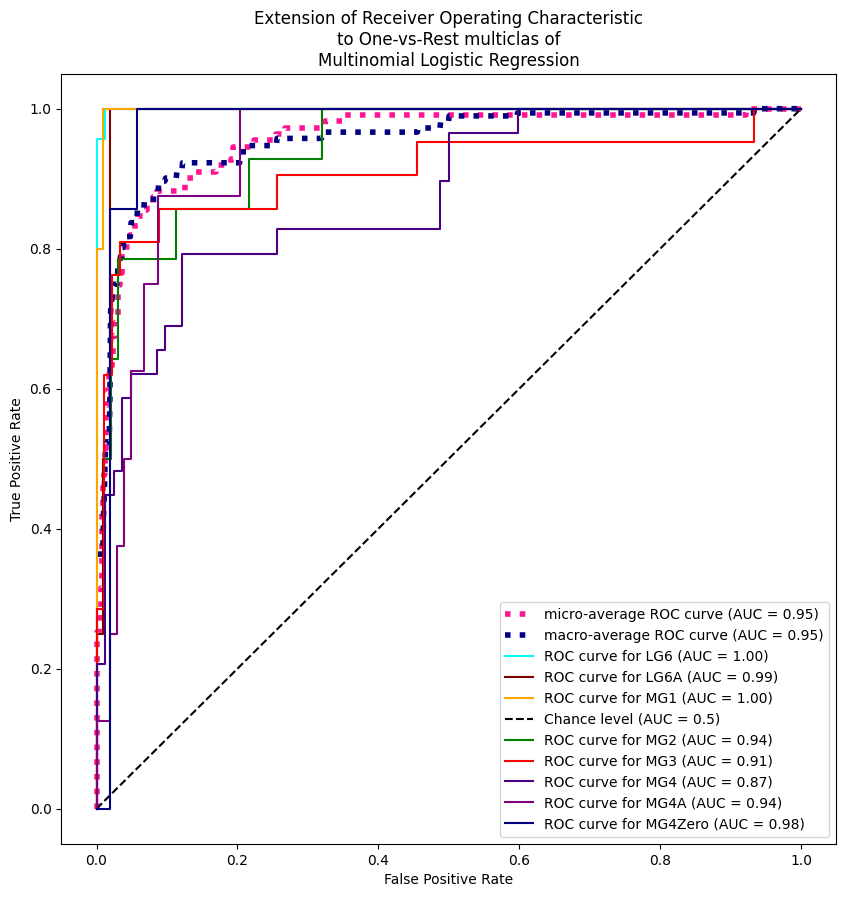

In [166]:
from itertools import cycle
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["cyan", "maroon", "orange", "green", "red", "indigo", "purple", "navy"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_testproba_mlr[:, class_id],
        name=f"ROC curve for {class_of_interest[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclas of\nMultinomial Logistic Regression",
)

plt.savefig("ROC_AUC_OV_MLR.png")

<ipython-input-167-d1948239cb76>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=plt.cm.get_cmap("tab10")(i),  # Use different colors for each class
<ipython-input-167-d1948239cb76>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=plt.cm.get_cmap("tab10")(i),  # Use different colors for each class
<ipython-input-167-d1948239cb76>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=plt.cm.get_cmap("tab10")(i),  # Use different colors for each class
<ipython-i

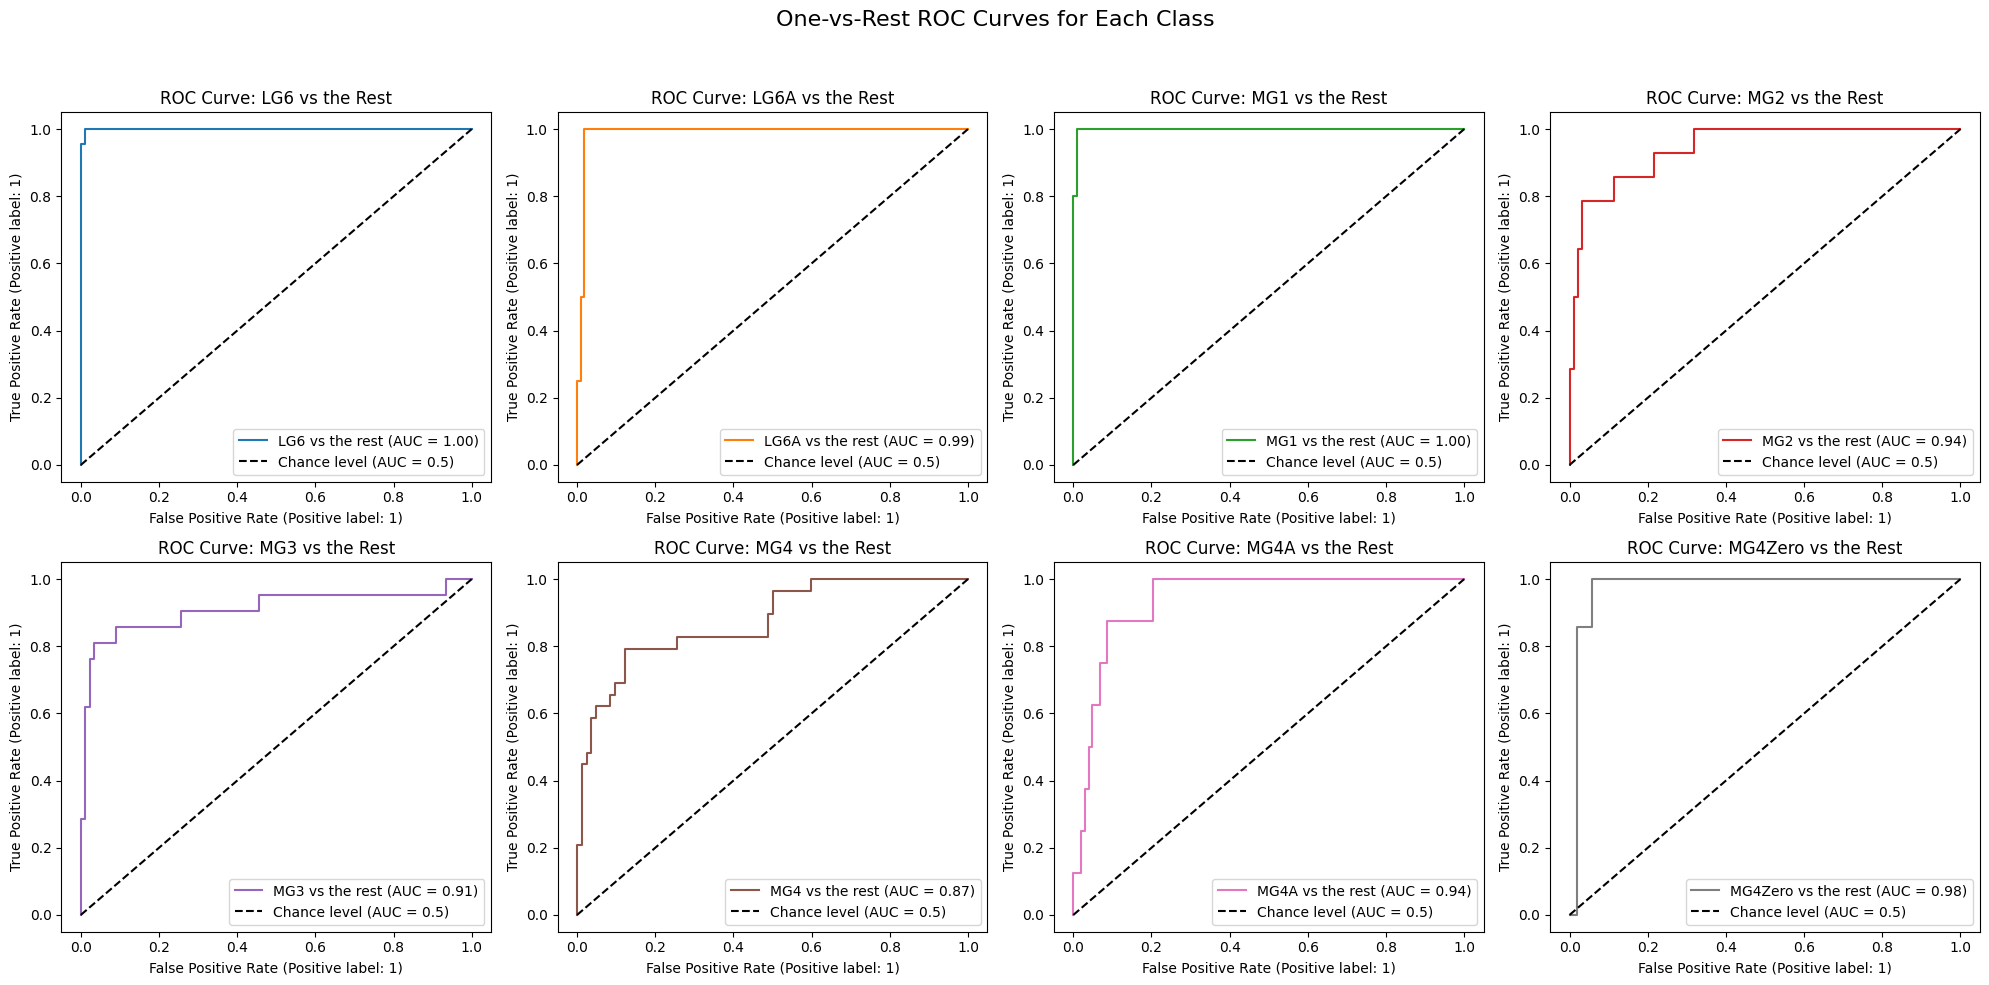

In [167]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

# Adjust the number of rows and columns
n_cols = 4
n_rows = 2

# Create a figure and a grid of subplots (2 rows and 4 columns)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))  # Adjust the figure size if needed
axes = axes.ravel()  # Flatten the 2D array of axes to iterate over it easily

# Loop over each class and its corresponding subplot
for i, class_name in enumerate(class_of_interest):
    class_id = list(label_binarizer.classes_).index(class_name)  # Get the class ID from the binarizer

    # Plot ROC curve in the i-th subplot (axes[i])
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],    # True binary labels for this class
        y_pred_testproba_mlr[:, class_id],  # Predicted probabilities for this class
        ax=axes[i],                    # Specify which subplot to use
        name=f"{class_name} vs the rest",
        color=plt.cm.get_cmap("tab10")(i),  # Use different colors for each class
        plot_chance_level=True
    )
    axes[i].set_title(f"ROC Curve: {class_name} vs the Rest")  # Set a title for each subplot

# Set the global title, labels, and adjust the layout
fig.suptitle("One-vs-Rest ROC Curves for Each Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to not overlap with the title

# Save the figure as a PNG file
plt.savefig("roc_curves_mlr1.png", dpi=600)

# Show the plot (optional)
plt.show()

---
### Visualisasi Hasil - LDA

In [168]:
n_classes = len(class_of_interest)
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_testproba_lda.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.94


In [169]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_pred_testproba_lda,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.95


In [170]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_testproba_lda[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.95


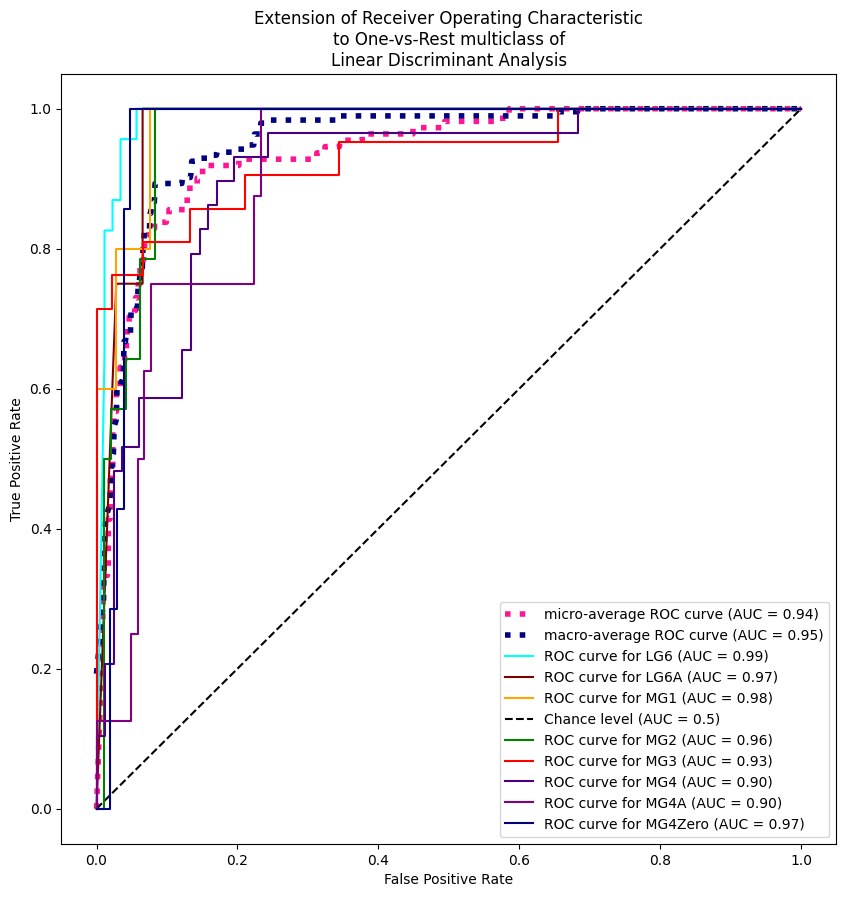

In [171]:
from itertools import cycle
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["cyan", "maroon", "orange", "green", "red", "indigo", "purple", "navy"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_testproba_lda[:, class_id],
        name=f"ROC curve for {class_of_interest[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass of\nLinear Discriminant Analysis",
)

plt.savefig("ROC_AUC_OV_LDA.png")

---
**Model Visualization - Linear Discriminant Analysis**


<ipython-input-172-c8e23e31db1b>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=plt.cm.get_cmap("tab10")(i),  # Use different colors for each class
<ipython-input-172-c8e23e31db1b>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=plt.cm.get_cmap("tab10")(i),  # Use different colors for each class
<ipython-input-172-c8e23e31db1b>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=plt.cm.get_cmap("tab10")(i),  # Use different colors for each class
<ipython-i

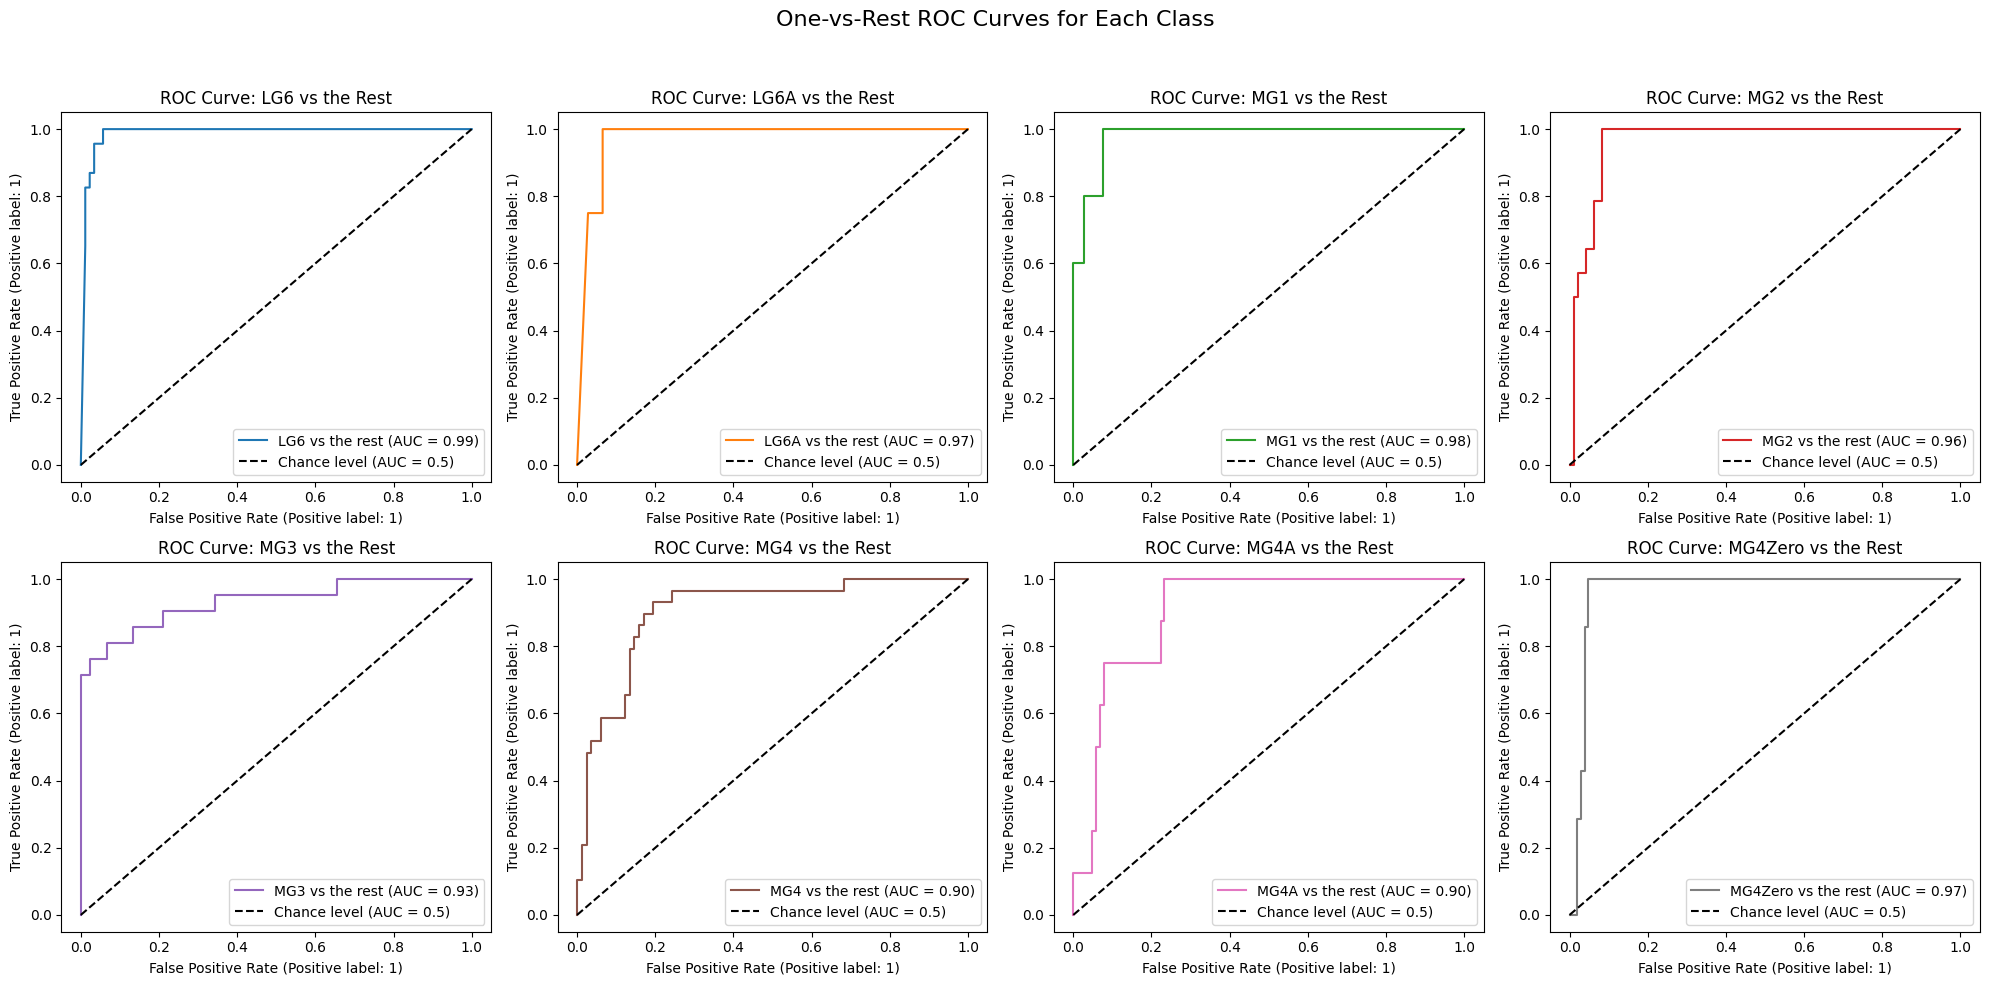

In [172]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

# Adjust the number of rows and columns
n_cols = 4
n_rows = 2

# Create a figure and a grid of subplots (2 rows and 4 columns)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))  # Adjust the figure size if needed
axes = axes.ravel()  # Flatten the 2D array of axes to iterate over it easily

# Loop over each class and its corresponding subplot
for i, class_name in enumerate(class_of_interest):
    class_id = list(label_binarizer.classes_).index(class_name)  # Get the class ID from the binarizer

    # Plot ROC curve in the i-th subplot (axes[i])
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],    # True binary labels for this class
        y_pred_testproba_lda[:, class_id],  # Predicted probabilities for this class
        ax=axes[i],                    # Specify which subplot to use
        name=f"{class_name} vs the rest",
        color=plt.cm.get_cmap("tab10")(i),  # Use different colors for each class
        plot_chance_level=True
    )
    axes[i].set_title(f"ROC Curve: {class_name} vs the Rest")  # Set a title for each subplot

# Set the global title, labels, and adjust the layout
fig.suptitle("One-vs-Rest ROC Curves for Each Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to not overlap with the title

# Save the figure as a PNG file
plt.savefig("roc_curves_lda1.png", dpi=600)

# Show the plot (optional)
plt.show()

Now we dive into evaluation and conclusion!

---
# **Model Evaluation, and Conclusion**

Perbandingan Hasil Klasifikasi antara:
- Dummy (Baseline Model)
- Random Forest
- Decision Tree Classifier + Bagging
- Multinomial Logistic Regression
- Linear Discriminant Analysis

Disebabkan ketidakseimbangan (*imbalance* pada tiap kelas namun di saat yang sama kita hendak mencari akurasi, pada kasus ini kita pakai accuracy dan log loss, dan melihat bagaimana sebaran pada masing-masing nilai akurasi pada tiap kelas target

----
**Conclusion**

- We can not simply use simple standardization of the data preprocessing since the nature of data itself is compositional.
- Random Forest and Decision Tree is not preferable in this case due to their vulnerability with data overfitting,
although works pretty well in training dataset. It can be proven while we try to do data validation by compare valid dataset to training dataset
- The Author chooses Linear Discriminant Model because it’s consistency with the overall performance of accuracy. Although the dataset separation method are different, it is proven while we try to do data validation by compare valid dataset to training dataset
- Multinomial Logistic Regression is a good alternative if we considering logarithmic loss to evaluate the model’s confidence in predictions, since it provides a continuous metric for probabilistic classifiers and is ideal when we want to measure the model’s uncertainty along with correctness.


That is all, and thank you for keeping up to the bottom part!